# CNN

In [64]:
# Import package
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf                               # prima: 'pip install tensorflow' da prompt anaconda
import tensorflow.keras                               # keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Conv2D, Flatten, Dropout, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os                                             # per gestire caricamento file

from IPython.display import Image                     # per importare in una cella di tipo CODICE un'immagine

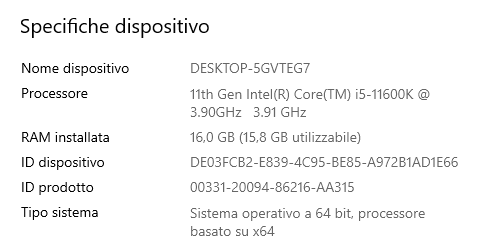

In [65]:
Image(filename='images/specifiche_mio_PC.png', width=800)

# Vehicle (car) 
Dal libro *Algoritmi per l'Intelligenza Artificiale* di Roberto Marmo (cap. 20).<br><br>
Costruiamo una semplice CNN per analizzare i segnali tridimensionali prodotti da un semplice sensore (**un accelerometro**), che è posizionabile su un'infinità di veicoli ed oggetti, e prevedere, in questo esempio, se il mezzo di trasporto dal quale provengono i segnali (cioè su cui si viaggia) è un'auto oppure no.

Download dei dati [qui](https://www.kaggle.com/claudiobottari/mobile-accelerometer-car-12k).<br>
Già scaricato qui sotto:

In [66]:
df = pd.read_csv('data/mobile-accelerometer-car-12k.csv')
df.head()
                            # --> i valori del sensore per alcune coordinate spaziali x,y,z.
                            #     target = 1, il veicolo è un'auto.
                            #     in un intervallo di un secondo l'acceleratore genera 100 righe.

acc_x     acc_y     acc_z  target
0 -0.113725  0.083797  9.654618       0
1 -0.098162  0.087388  9.630676       0
2 -0.099359  0.094571  9.645041       0
3 -0.099359  0.089783  9.649830       0
4 -0.118513  0.087388  9.634268       0

In [67]:
df.describe()

acc_x          acc_y          acc_z         target
count  120000.000000  120000.000000  120000.000000  120000.000000
mean       -0.354549       5.367115       6.729311       0.500000
std         1.931744       3.420114       2.588606       0.500002
min       -12.509735     -19.051361     -19.093689       0.000000
25%        -1.116619       1.902695       4.829160       0.000000
50%        -0.529119       6.922834       6.459327       0.500000
75%        -0.092177       8.182184       9.212952       1.000000
max        36.782090      13.737244      60.973206       1.000000

In [68]:
df.shape

(120000, 4)

## Pre-processing

Costruiamo una array numpy per X e y dai dati del dataframe.

In [69]:
X = df[['acc_x', 'acc_y', 'acc_z']].values
y = df[['target']].values
print(X.shape, y.shape)

(120000, 3) (120000, 1)


Rimodellazione del dataset (le due array) secondo le 100 righe /secondo, dividendo X e Y.

In [70]:
X = X.reshape(df.shape[0]//100, 100, 3)
y = y.reshape(df.shape[0]//100, 100)[:, 0]
print(X.shape, y.shape)

(1200, 100, 3) (1200,)


Suddivisione in Training e Test dataset (25%)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23, shuffle=True)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(900, 100, 3) (900,)
(300, 100, 3) (300,)


## Impostazione del modello

Creazione della rete CNN. 

In [72]:
model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', input_shape=X.shape[1:], name='conv_1'),
    MaxPooling1D(name='max_pool_1'),
    Conv1D(32, kernel_size=3, activation='relu', name='conv_2'),
    MaxPooling1D(name='max_pool_2'),
    Conv1D(16, kernel_size=3, activation='relu', name='conv_3'),
    MaxPooling1D(name='max_pool_3'),
    GlobalMaxPooling1D(name='global_max'),
    Dense(1, activation='sigmoid', name='fully_connected_output')], name='vehicle_cnn_baseline')

model.summary()   # --> riporta i dettagli del modello usato, per comprendere come sono state organizzate
                  #     le varie componenti.

Model: "vehicle_cnn_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv1D)             (None, 98, 16)            160       
                                                                 
 max_pool_1 (MaxPooling1D)   (None, 49, 16)            0         
                                                                 
 conv_2 (Conv1D)             (None, 47, 32)            1568      
                                                                 
 max_pool_2 (MaxPooling1D)   (None, 23, 32)            0         
                                                                 
 conv_3 (Conv1D)             (None, 21, 16)            1552      
                                                                 
 max_pool_3 (MaxPooling1D)   (None, 10, 16)            0         
                                                                 
 global_max (GlobalMaxPoolin  (None, 16)      

Imposta l'ottimizzatore, il learning rate e la loss function.

In [73]:
model.compile(optimizer=Adam(learning_rate=3e-3), loss='binary_crossentropy', metrics=['accuracy'])

## Allenamento

In [74]:
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), verbose=2, batch_size=150)
                                      # per la scelta del miglior batch-size vedi le slide di 'Introduzione alle NN'.

Epoch 1/25
6/6 - 0s - loss: 0.5001 - accuracy: 0.7611 - val_loss: 0.2324 - val_accuracy: 0.9433 - 426ms/epoch - 71ms/step
Epoch 2/25
6/6 - 0s - loss: 0.2197 - accuracy: 0.9367 - val_loss: 0.1630 - val_accuracy: 0.9467 - 43ms/epoch - 7ms/step
Epoch 3/25
6/6 - 0s - loss: 0.1948 - accuracy: 0.9367 - val_loss: 0.1577 - val_accuracy: 0.9433 - 43ms/epoch - 7ms/step
Epoch 4/25
6/6 - 0s - loss: 0.1924 - accuracy: 0.9278 - val_loss: 0.1516 - val_accuracy: 0.9367 - 42ms/epoch - 7ms/step
Epoch 5/25
6/6 - 0s - loss: 0.1852 - accuracy: 0.9356 - val_loss: 0.1469 - val_accuracy: 0.9400 - 42ms/epoch - 7ms/step
Epoch 6/25
6/6 - 0s - loss: 0.1754 - accuracy: 0.9244 - val_loss: 0.1502 - val_accuracy: 0.9400 - 45ms/epoch - 7ms/step
Epoch 7/25
6/6 - 0s - loss: 0.1677 - accuracy: 0.9378 - val_loss: 0.1384 - val_accuracy: 0.9433 - 46ms/epoch - 8ms/step
Epoch 8/25
6/6 - 0s - loss: 0.1622 - accuracy: 0.9289 - val_loss: 0.1442 - val_accuracy: 0.9400 - 44ms/epoch - 7ms/step
Epoch 9/25
6/6 - 0s - loss: 0.1549 - a

Ora il plot dell'andamento dell'accuratezza del modello e della loss function del modello stesso durante le 25 epoche, sia nel training che nel test set.

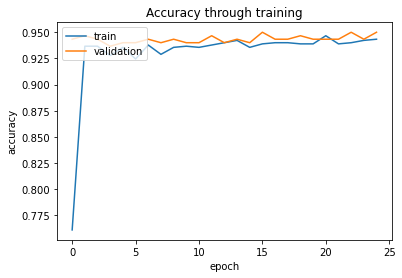

In [75]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy through training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

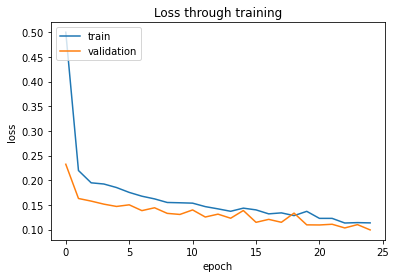

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss through training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Valutazione del modello sul test

Calcolo delle previsioni e della confusion matrix, plot di alcune metriche.

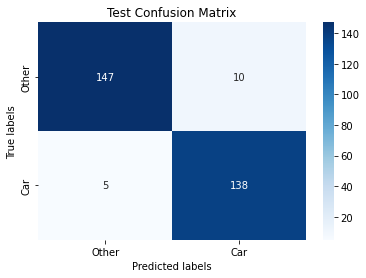

In [77]:
y_pred = model.predict(X_test)

ax = plt.subplot()
cm = metrics.confusion_matrix(y_test, (y_pred > 0.5))
sns.heatmap(cm, cmap= 'Blues', annot= cm, ax = ax, fmt="d")

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Test Confusion Matrix')
ax.xaxis.set_ticklabels(['Other', 'Car'])
ax.yaxis.set_ticklabels(['Other', 'Car'])
plt.show()

In [78]:
# accuracy: (tp + tn) / (p + n)
accuracy = metrics.accuracy_score(y_test, (y_pred > 0.5))
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = metrics.precision_score(y_test, (y_pred > 0.5))
print('Precision: %f' % precision)
# recall: tp / (tp + fn)\\\\\
recall = metrics.recall_score(y_test, (y_pred > 0.5))
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = metrics.f1_score(y_test, (y_pred > 0.5))
print('F1 score: %f' % f1)

Accuracy: 0.950000
Precision: 0.932432
Recall: 0.965035
F1 score: 0.948454


Esistono altri modelli CNN per comprendere se il mezzo di trasporto è, oltre all'auto, il treno, la metropolitana, la moto, la bicicletta, lo spostamento a piedi e lo stare fermi.<br>
Esistono modelli CNN per capire l'attività svolta dall'utente su uno smartphone: scrivendo, scorrendo le scheramte, selezionando qualcosa, ecc.

# Tensori
**Piccola introduzione**.<br>
Un tensore è:
* la generalizzazione di una matrice ad n dimensioni;
* di valori arbitrari;
* con una base (un sistema di riferimento);
* con alcune operazioni possibili.

**Esempio: al visione dei colori RGB**:
* ad ogni pixel è assegnata una terna di valori formata dalle quantità di rosso (R), verde (G) e blu (B), ognuna espressa in un certo numero di bit;
* le tre quantità venfono sommate per formare il pixel;
* un'immagine è dunque rappresentata tramite una matrice (tensore) tri-dimensionale composta dalla sequenza delle tre matrici bi-dimensionali (la risoluzione length x width);
* ogni pixel dell'immagine è dunque descritto dai tre numeri che ne esprimono il colore in RGB.

I tensori sono <u>molto usati nel deep learning</u>, in particolare nella **classificazione di immagini**.

In [24]:
# crea un piccolo tensore 3x3x3:
from numpy import array
T = array([
  [[1,2,3],    [4,5,6],    [7,8,9]],
  [[11,12,13], [14,15,16], [17,18,19]],
  [[21,22,23], [24,25,26], [27,28,29]],
  ])
print(T.shape)
print(T)

(3, 3, 3)
[[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]]

 [[11 12 13]
  [14 15 16]
  [17 18 19]]

 [[21 22 23]
  [24 25 26]
  [27 28 29]]]


Come detto, nel caso 3D il tensore è visualizzato come una serie di matrici 2D, una per ogni livello della terza dimensione:
* l'asse 0 specifica il livello (la terza dimensione);
* l'asse 1 specifica la riga;
* l'asse 2 specifica la colonna.

**Note su TensorFlow**:
* una framework *open-source* sotto licenza *Apache 2.0* creato da Google Brain nel 2015 e poi rivisto nel 2019 (TensorFlow 2);<br><br>
* scopo: supportare la costruzione di reti neurali profonde, con alte prestazioni;<br><br>
* il nome deriva appunto da *Tensor* e da *Flow*, il flusso dei tensori lungo la rete, che diventa così una rete di tensori;<br><br>
* sviluppato in *C++* con interfacce per *Python, C++, R*;<br><br>
* l'interfaccia più solida e completa è quella di *Python*;<br><br>
* supporta la computazione parallela e distribuita e la computazione su *GPU* (se disponibili), con miglioramento anche notevole delle prestazioni computazionali;<br><br>
* configurazioni hardware avanzate: centinaia di macchine dedicate con migliaia di GPU;<br><br>
* grande disponibilità on-line di risorse, documentazione, video, tutorial;<br><br>
* lo stato dell'apprendimento è visualizazbile in tempo reale con *TensorBoard*;<br><br>
* è possibile provare TensorFlow nel browser, senza necessità di installarlo, se si dispone della libreria *Node.js* in *JavaScript*;<br><br>
* *TensorFlow Lite* gira anche su dispositivi locali basati su *iOS* od *Android*;<br><br>
* la progettazione di un grafo TensorFlow richiede la specifica di un gran numero di parametri; sono state perciò realizzate delle librerie di alto livello (ad es. *Keras*) che semplificano molto questo processo e che forniscono dei layer pre-configurati;<br><br>
* TensorFlow 2 fornisce la *eager execution*, un meccanismo che permette di ottenere subito il risultato, come avviene normalmente in Python, senza l'obbligo di creare un grafo.

In [25]:
import tensorflow as tf
print(tf.__version__)

2.8.0


A scopo didattico, il codice seguente costruisce il **grafo computazionale**, anche detto *tensor graph*, che è l'idea base originale di TensorFlow.<br><br>
E' un grafo **diretto aciclico** che rapresenta una computazione.<br><br>
Ogni nodo è **un'operazione** (chiamata *ops*), che accetta in input 0 o più tensori e restituisce 0 o più tensori;<br><br>
Gli archi rappresentano il flusso dei dati (i tensori).<br><br>
I tensori sono appunto i dati che percorrono gli archi. Dagli input si arriva così, progressivamente, agli output, seguendo le direzioni degli archi.<br><br>
E' un grafo **statico**, creato una sola volta e non più modificato. [TensorFlow 2 ha superato questo limite di TensorFlow 1 ed ha introdotto i grafi **dinamici**]. <br><br>
Esaminiamo il grafo computazionale dell'operazione ((5+5+2)x5)/6:

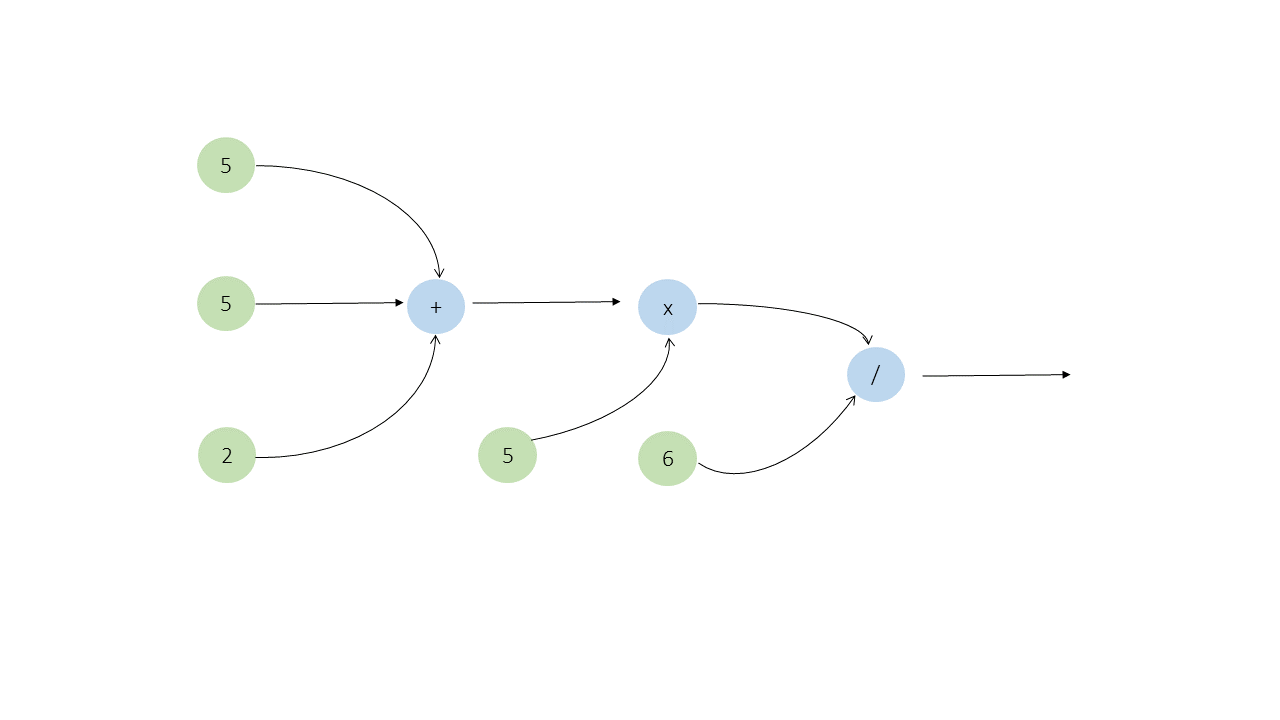

In [26]:
Image(filename='images/Comp_graph.png', width=1200)

Il grafo computazionale è percorso da sx a dx, lungo gli archi.<br><br>
I nodi verdi sono le costanti, un'operazione che prende in input 0 tensori e restituisce un tensore.<br><br>
I nodi blu rappresentano i calcoli intermedi; il primo nodo, ad esempio, prende in input tre tensori (5,5,2) e restituisce un tensore (5+5+2).<br><br>
L'ultimo nodo a dx restituisce il tensore del risultato finale.<br><br>
NB. TensorFlow 2 non richiede la costruzione del grafo, che tuttavia è consigliata per aumentare la velocità di calcolo

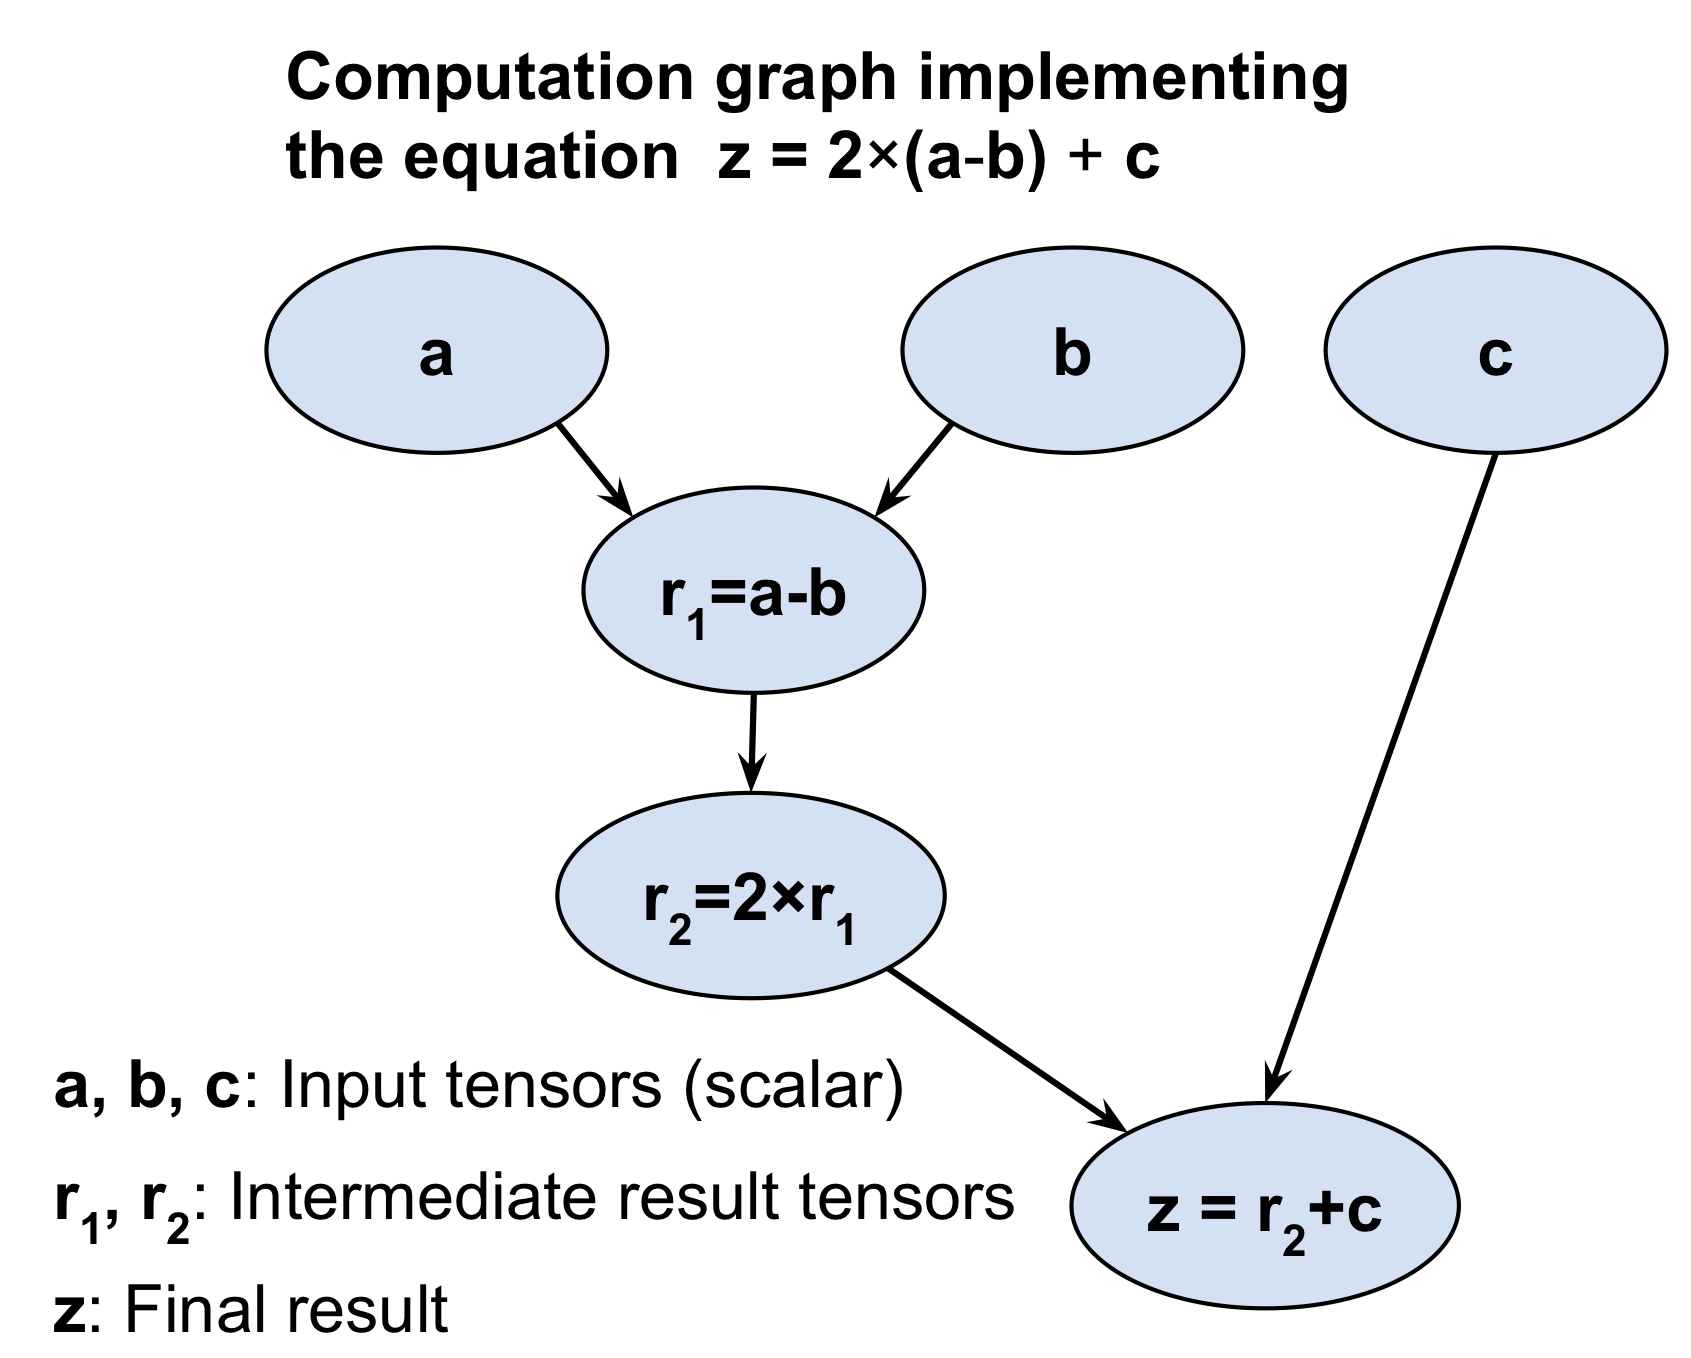

In [27]:
Image(filename='images/Comp_graph2.png', width=600)  # un altro esempio di grafo computazionale

Ora alcune semplici operazioni:

In [28]:
# crea un tensore
x = [[2.]]
m = tf.square(x)
print("Descrizione di m:",m)
print("Contenuto di m:",m.numpy())
# moltiplica due tensori
a = tf.constant([[2, 2],[3, 4]])
b = tf.constant([[2, 1], #separare le righe aumenta leggibilità
                 [3, 2]])
ab = tf.matmul(a, b)
print('a * b = \n', ab.numpy())

Descrizione di m: tf.Tensor([[4.]], shape=(1, 1), dtype=float32)
Contenuto di m: [[4.]]
a * b = 
 [[10  6]
 [18 11]]


In [29]:
@tf.function # definisce operazione su tensore
def f(x): return tf.add(x, 1.) # aggiunge 1 a tensore x

In [30]:
a = tf.constant("Benvenuto in TensorFlow 2.0!")# tensore con una stringa
print(a)
print(a.numpy())

tf.Tensor(b'Benvenuto in TensorFlow 2.0!', shape=(), dtype=string)
b'Benvenuto in TensorFlow 2.0!'


In [31]:
scalar = tf.constant(1.0)                      # il tensore contiene una costante
vector = tf.constant([1.0, 1.0])               # il tensore come array con 2 costanti
matrix = tf.constant([[3.0, 2.0], [6.0, 4.0]]) # il tensore come matrice 2x2 con 4 costanti
print(f(scalar))
print(f(vector))
print(f(matrix))

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor([2. 2.], shape=(2,), dtype=float32)
tf.Tensor(
[[4. 3.]
 [7. 5.]], shape=(2, 2), dtype=float32)


In [32]:
# calcolo del grafo visto prima:
a=tf.constant(5)
b=tf.constant(8)
c=tf.constant(2)
d=tf.constant(3)
e=tf.constant(6)
f=((a+b+c)*d)/e
print(f)
print(f.numpy())

tf.Tensor(7.5, shape=(), dtype=float64)
7.5


Ora creiamo un computational graph con i due approcci.

In [33]:
import numpy as np
data = np.array([[ 1.764,  0.400],
       [ 0.978,  2.240],
       [ 1.867, -0.977],
       [ 2.467, -0.107]])

In [34]:
input = tf.keras.layers.InputLayer(input_shape=(2))     # input layer con 2 valori
hidden = tf.keras.layers.Dense(3, activation='relu')    # 1 hidden layer denso con 3 neuroni
output = tf.keras.layers.Dense(1, activation='sigmoid') # output layer denso con 1 neurone

Usiamo *Keras* per creare il modello della rete ed il contenuto delle variabili:

In [35]:
# crea il modello con approccio di chiamata a funzione ed esecuzione dinamica;
# i dati di input vanno nel primo livello, che è il primo nodo;
# quando aggiunge il secondo nodo, l'output del primo nodo viene inserito nel secondo nodo
# e viene calcolato l'output del secondo nodo e così via;
# consente di stampare stati intermedi del modello, ma rallenta molto i calcoli;
def model_1(data): 
  x = input(data)
  x = hidden(x)
  print('Dopo il primo layer:', x)
  out = output(x)
  print('Dopo il secondo layer:', out)
  return out

In [36]:
print('Output come tensore:', model_1(data))
print('Output come valori:\n', model_1(data).numpy())

Dopo il primo layer: tf.Tensor(
[[0.        0.859131  0.       ]
 [0.        0.        0.       ]
 [0.        1.7423986 0.       ]
 [0.        1.5979794 0.       ]], shape=(4, 3), dtype=float32)
Dopo il secondo layer: tf.Tensor(
[[0.4435656 ]
 [0.5       ]
 [0.38703895]
 [0.3961178 ]], shape=(4, 1), dtype=float32)
Output come tensore: tf.Tensor(
[[0.4435656 ]
 [0.5       ]
 [0.38703895]
 [0.3961178 ]], shape=(4, 1), dtype=float32)
Dopo il primo layer: tf.Tensor(
[[0.        0.859131  0.       ]
 [0.        0.        0.       ]
 [0.        1.7423986 0.       ]
 [0.        1.5979794 0.       ]], shape=(4, 3), dtype=float32)
Dopo il secondo layer: tf.Tensor(
[[0.4435656 ]
 [0.5       ]
 [0.38703895]
 [0.3961178 ]], shape=(4, 1), dtype=float32)
Output come valori:
 [[0.4435656 ]
 [0.5       ]
 [0.38703895]
 [0.3961178 ]]


In [37]:
@tf.function  # crea modello con approccio creazione grafo statico;
              # prima collega tutti i nodi facendo una grande operazione computazionale;
              # quindi segue il flusso del grafo per fare i calcoli, non mostra stati intermedi 
              # del modello né aggiunge nodi al volo, ma è più veloce dell'altro approccio.
def model_2(data):
  x = input(data)
  x = hidden(x)
  print('Dopo il primo layer:', x)
  out = output(x)
  print('Dopo il secondo layer:', out)
  return out

In [38]:
print('Output come tensore:', model_2(data))

Dopo il primo layer: Tensor("dense/Relu:0", shape=(4, 3), dtype=float32)
Dopo il secondo layer: Tensor("dense_1/Sigmoid:0", shape=(4, 1), dtype=float32)
Output come tensore: tf.Tensor(
[[0.4435656 ]
 [0.5       ]
 [0.38703895]
 [0.3961178 ]], shape=(4, 1), dtype=float32)


In [180]:
# come misurare i tempi di esecuzione di una cella:
import time
start_time = time.time()
c=3 # il codice
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0 seconds ---


In [37]:
import tensorflow_datasets as tfds
print("Elenco data set in TensorFlow 2.o", tfds.list_builders())
data, info = tfds.load(name='fashion_mnist', as_supervised=True, split=None, with_info=True)
print("Descrizione data set MNIST",info)

Elenco data set in TensorFlow 2.o ['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'arc', 'asset', 'assin2', 'bair_robot_pushing_small', 'bccd', 'beans', 'bee_dataset', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'booksum', 'bool_q', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cardiotox', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'cherry_blossoms', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'coqa', 'cos_e', 'cosmos_qa', 'covid19', 'covid19sum', 'crema_d', 'cs_restaurants', 'curated_breast_imaging_ddsm', 'cycle_gan', 'd4rl_adroit_door', 'd4rl_adroit_hammer', 'd4rl_adroit_pen',

Come si vede dai tempi di esecuzione, l'approccio con grafo è più veloce perchè il grafo è costruito una sola volta e poi riusato; non mostra dati intermedi.

In [43]:
# dataset disponibili in TensorFlow 2:
import tensorflow_datasets as tfds      # prima fare 'pip install tensorflow_datasets' da un prompt anaconda
print("Elenco dei datset di TensorFlow 2","\n",tfds.list_builders())
data,info = tfds.load(name='fashion_mnist',as_supervised=True,split=None,with_info=True)
print()
print("Descrizione del dataset MNIST","\n",info)

Elenco dei datset di TensorFlow 2 
 ['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'arc', 'asset', 'assin2', 'bair_robot_pushing_small', 'bccd', 'beans', 'bee_dataset', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'booksum', 'bool_q', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cardiotox', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'cherry_blossoms', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'coqa', 'cos_e', 'cosmos_qa', 'covid19', 'covid19sum', 'crema_d', 'cs_restaurants', 'curated_breast_imaging_ddsm', 'cycle_gan', 'd4rl_adroit_door', 'd4rl_adroit_hammer', 'd4rl_adroit_pen

# Classificazione di immagini con CNN

La differenza tra convolutional e pooling layer [qui](https://stackoverflow.com/questions/43485361/whats-the-difference-between-conv-layer-and-pooling-layer-in-cnn) e [qui](https://www.quora.com/What-is-the-difference-between-a-convolutional-layer-and-a-pooling-layer).<br>
[Ottima introduzione grafica alle CNN](https://towardsdatascience.com/understanding-convolutions-and-pooling-in-neural-networks-a-simple-explanation-885a2d78f211).<br>
[Ottima introduzione software alle CNN](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/).

## Cani e gatti
Creiamo una CNN per distinguere cani e gatti.<br><br>
Il set di dati "cani vs gatti" fu usato per una competizione di apprendimento automatico Kaggle tenutasi nel 2013.<br><br>
Il set di dati proviene da un set di dati molto più ampio di 3 milioni di foto annotate manualmente. Il set di dati è stato sviluppato come una partnership tra Petfinder.com e Microsoft.<br>
Il set di dati è stato originariamente utilizzato come **CAPTCHA** (o test di Turing pubblico completamente automatizzato per distinguere i computer e gli esseri umani), ovvero un compito che si ritiene un essere umano trovi banale ma che non può essere risolto da una macchina, utilizzato appunto sui siti Web per distinguere tra utenti umani e bot. In particolare, l'attività è stata denominata "Asirra" o riconoscimento di immagini di specie animali per la limitazione dell'accesso, un tipo di CAPTCHA. L'attività è stata descritta nell'articolo del 2007 intitolato "Asirra: A CAPTCHA that Exploits Manual Image Categorization".<br>
* *Vi presentiamo Asirra, un CAPTCHA che chiede agli utenti di identificare i gatti da un set di 12 fotografie di cani e gatti. Asirra è facile per gli utenti; studi sugli utenti indicano che può essere risolto dagli esseri umani il 99,6% delle volte in meno di 30 secondi. Salvo un grande progresso nella visione artificiale, prevediamo che i computer non avranno una possibilità migliore di 1/54.000 di risolverlo.*<br>

Al momento della pubblicazione del concorso, il miglior risultato fu ottenuto con un SVM e descritto in un documento del 2007 dal titolo "Machine Learning Attacks Against the Asirra CAPTCHA" (PDF) che raggiunse l'80% di precisione di classificazione. A seguito di questo risultato si comprese che l'attività non era più adatta per un CAPTCHA.

* *… descriviamo un classificatore accurato all'82,7% nel distinguere le immagini di cani e gatti usati ad Asirra. Questo classificatore è una combinazione di classificatori di macchine vettoriali di supporto addestrati su caratteristiche di colore e texture estratte dalle immagini. […] I nostri risultati suggeriscono cautela contro l'impiego di Asirra.*

Il concorso Kaggle fornì **25.000 foto etichettate**: 12.500 cani e lo stesso numero di gatti. Furono quindi richieste previsioni su un set di dati di prova di 12.500 fotografie senza etichetta. Il concorso fu vinto da Pierre Sermanet (attualmente ricercatore presso Google Brain) che ottenne un'accuratezza di classificazione di circa il 98,914% su un sottocampione del 70% del set di dati del test. Il suo metodo è stato successivamente descritto come parte del documento del 2013 intitolato "OverFeat: Integrated Recognition, Localization and Detection using Convolutional Networks".

Il set di dati è semplice da capire e abbastanza piccolo da poter essere caricato in memoria. In quanto tale, è diventato un buon set di dati di visione artificiale del tipo "ciao mondo" per i principianti delle reti neurali convoluzionali.

Pertanto, è normale ottenere una precisione di circa l'80% con una rete neurale convoluzionale progettata manualmente e una precisione superiore al 90% utilizzando il *transfer learning* (cioè i classificatori pre-allenati).





Il set di dati può essere scaricato gratuitamente dal [sito Web di Kaggle](https://www.kaggle.com/datasets/tongpython/cat-and-dog).<br>
E' un file di circa 850 megabyte: "dogs-vs-cats.zip".<br>
Decomprimiamo il file, si vedrà:
* train.zip
* train1.zip
* e un file .csv. 

Decomprimiamo il file train.zip, poiché ci concentreremo solo su questo set di dati.<br><br>
Il file decompresso, composto di 12.500 foto di gatti ed altrettante di cani, è scaricato nella directory (del mio PC):<br> **Corso Reti Neurali/data/dogs-vs-cats/train_all**.

Il set di dati *Dogs vs. Cats* è un set di dati di visione artificiale standard che prevede la classificazione delle foto come contenenti un cane o un gatto.<br>
Sebbene il problema possa sembrare semplice, è stato affrontato in modo efficace solo negli ultimi anni utilizzando reti neurali convoluzionali di deep learning. Sebbene il set di dati sia effettivamente risolto, può essere utilizzato come base per l'apprendimento e la pratica su come sviluppare, valutare e utilizzare reti neurali convoluzionali di apprendimento profondo per la classificazione delle immagini da zero.<br>
Vedremo come realizzare una infrastruttura di test per per stimare le prestazioni del modello, come esplorare i miglioramenti al modello e come salvare il modello e caricarlo successivamente per fare previsioni su nuovi dati.

### Preparazione del dataset

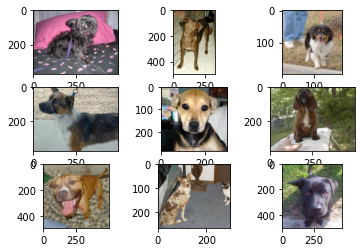

In [3]:
# plot esemplificativo dei primi 9 cani:
import matplotlib.pyplot as plt
from matplotlib.image import imread
# define location of dataset
folder = "data/dogs-vs-cats/train_all"               # la sorgente dei dati
# plot first few images
for i in range(9):                                   # le prime 10 foto di cani
    # plt.figure(figsize=(10, 10))
    # define subplot
    plt.subplot(330 + 1 + i)
    # define filename
    filename = folder + '/dog.' + str(i) + '.jpg'
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()

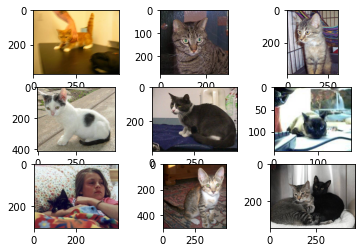

In [4]:
# plot esemplificativo dei primi 9 gatti:
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = "data/dogs-vs-cats/train_all"              # la sorgente dei dati
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # define filename
    filename = folder + '/cat.' + str(i) + '.jpg'   # le prime 10 foto di gatti
    # load image pixels
    image = imread(filename)
    # plot raw pixel data
    pyplot.imshow(image)
# show the figure
plt.show()

Il classificatore dovrà essere robusto: in una foto i gatti sono due, in un'altra il gatto è sotto le coperte insieme alla padrona!<br><br>
Alcune foto sono in formato *landscape*, altre in formato *portrait*, ed altre ancora in formato quadrato.<br><br>
Le foto devono dunque essere rimodellate (*reshaping*).<br><br>
Potremmo caricare tutte le foto e guardare la distribuzione delle larghezze e delle altezze delle foto, quindi progettare una nuova dimensione della foto che rifletta al meglio ciò che è più probabile che vedremo nella pratica.<br><br>
Input più piccoli significano un modello più veloce da addestrare e in genere questo è l'aspetto più importante.<br><br>  Scegliamo una dimensione fissa di **200×200 pixel**.

Sono 25.000 immagini con 200x200x3 pixel ciascuna, ovvero 3.000.000.000 di valori di pixel a 32 bit. [Color depth](https://en.wikipedia.org/wiki/Color_depth).<br>
Dobbiamo caricare tutte le immagini in memoria, rimodellarle (on-line, cioè durante il caricamento stesso) ed archiviarle.<br>
Ci sono due modi:
* come un singolo *array NumPy*; funziona bene solo con 16+ GB di RAM;
* scrivere del codice personalizzato. 

L'esempio seguente (del primo modo) utilizza l'API di elaborazione delle immagini di **Keras** per caricare tutte le 25.000 foto nel set di dati di addestramento e rimodellarle in 200 × 200 foto quadrate (con le class *load_img* ed *img_to-array*). L'etichetta di ciascuna foro viene determinata in base ai nomi dei file. Viene quindi salvata su disco una tupla di foto ed etichette.<br>
Saltare l'esempio se non si dispone di almeno 12 GB di RAM. E' solo un esempio dimostrativo del primo modo.

In [5]:
# load dogs-vs-cats dataset, reshape it and save to a new file.

# sul mio PC occorrono circa 2.5 minuti di esecuzione, su altre macchine si può fare in un minuto circa.
# comunque occorrono almeno 12GB di RAM.

import time
start = time.time()


from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# define location of dataset (la sorgente)
folder = 'data/dogs-vs-cats/train_all/'
photos, labels = list(), list()

# enumerate files in the directory
for file in listdir(folder):
    # determine label (class)
    label = 0.0                 # 0 per cane (default)
    if file.startswith('cat'):  # 1 per gatto
        label = 1.0
    # load image
    photo = load_img(folder + file, target_size=(200, 200))  # reshape 200x200
    # convert to numpy array
    photo = img_to_array(photo)
    # store 
    photos.append(photo)
    labels.append(label)
    
# convert to numpy arrays (one shot)
photos = asarray(photos)           # un unico array per le foto
labels = asarray(labels)           # un unico array per le label
print(photos.shape, labels.shape)

# save the reshaped photos (nella sotto-directory 'data/dogs-cs-cats')
save('data/dogs-vs-cats/dogs_vs_cats_photos.npy', photos)
save('data/dogs-vs-cats/dogs_vs_cats_labels.npy', labels)
                                # --> i due file creati contengono tutte le foto ri-modellate e con la loro etichetta.
                                #     i due file sono grandi solo 12GB complessivamente e sono molto più veloci da 
                                #     caricare in memoria che le immagini singole.
            

end = time.time()
print(end - start)

(25000, 200, 200, 3) (25000,)
151.16735529899597


In [6]:
# load and confirm the shape (tempo necessario sul mio PC: qualche decina di secondi)
from numpy import load
photos = load('data/dogs-vs-cats/dogs_vs_cats_photos.npy')
labels = load('data/dogs-vs-cats/dogs_vs_cats_labels.npy')
print(photos.shape, labels.shape)
                            # --> stesse dimensioni di prima, il dataset è stato salvato e ricaricato correttamente:

(25000, 200, 200, 3) (25000,)


**In alternativa** (secondo modo di gestione), possiamo caricare le immagini progressivamente utilizzando la classe Keras *ImageDataGenerator* e l'API *flow_from_directory()*. Questo modo è più lento ma funziona su più macchine.

Questa API richiede preferenzialmente che i dati siano divisi in directory **train/** e **test/** separate e che in ciascuna directory ci sia una sottodirectory per ogni classe, ad esempio una sottodirectory *train/dogs/* e una *train/cats/* e lo stesso per test.<br><br> 
Ecco un codice che crea una copia del set di dati con questa struttura di directory. Selezioneremo casualmente il 25% delle immagini (ovvero 6.250) da utilizzare come test set. [Lo zip scaricato prima infatti NON contiene immagini di test.]<br><br>
Innanzitutto, dobbiamo creare la struttura della directory come segue:

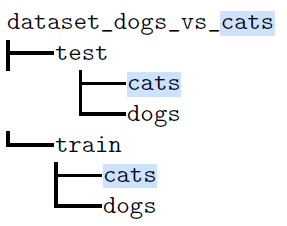

In [49]:
Image(filename='images/dogs_cats_dir_tree.png', width=200)

Possiamo creare directory usando la funzione *makedirs()* e usare un ciclo per creare le sottodirectory *dogs/* e *cats/* per entrambe le directory train/ e test/.

In [7]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'data/dogs-vs-cats/dogs-vs-cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)

Quindi, scorriamo tutti i file di immagine nel set di dati e copiamoli nella rispettiva sottodirectory in base al loro nome file.<br>
Inoltre, come detto, selezioniamo un 25% delle immagini per il set di dati di test. 

In [8]:
# seed random number generator (tempo necessario (sul mio PC): qualche decina di secondi)
seed(1)
# define ratio of pictures to use for validation (test)
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'data/dogs-vs-cats/train_all/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        copyfile(src, dst)

Ed infine un check delle immagini caricate.

In [10]:
# le sotto-directory da enumerare:
train_cats_dir = "data/dogs-vs-cats/dogs-vs-cats/train/cats"
train_dogs_dir = "data/dogs-vs-cats/dogs-vs-cats/train/dogs"
validation_cats_dir = "data/dogs-vs-cats/dogs-vs-cats/test/cats"
validation_dogs_dir = "data/dogs-vs-cats/dogs-vs-cats/test/dogs"

In [11]:
# i totali del training per classe:
num_dogs_tr = len(os.listdir(train_dogs_dir))
print("Numero immagini  cani di training:",num_dogs_tr)
num_cats_tr = len(os.listdir(train_cats_dir))
print("Numero immagini gatti di training:",num_cats_tr)

Numero immagini  cani di training: 9374
Numero immagini gatti di training: 9323


In [12]:
# i totali del test (validation) per classe:
num_dogs_val = len(os.listdir(validation_dogs_dir))
print("Numero immagini  cani di test:",num_dogs_val)
num_cats_val = len(os.listdir(validation_cats_dir))
print("Numero immagini gatti di test:",num_cats_val)

Numero immagini  cani di test: 3126
Numero immagini gatti di test: 3177


In [13]:
# i totali del training e del test dataset:
tot_train = num_cats_tr + num_dogs_tr
print(tot_train)
print()
tot_val = num_cats_val + num_dogs_val
print(tot_val)
print()
print(tot_train+tot_val)

18697

6303

25000


A questo punto abbiamo la struttura di directory per il caricamento, reshape e save con la classe Keras *ImageDataGenerator* e l'API *flow_from_directory()*. [Come detto, questo modo è più lento ma funziona su più macchine.]<br>
Utilizzeremo queste classi sia nell'esempio con la CNN che in quello con la VGG.

### CNN 
La classificazione del dataset cani-gatti con una CNN (VGG). [Dal libro *Algoritmi per l'Intelligenza Artificiale* di Roberto Marmo)].<br><br>
La VGG è un tipo di rete non modernissima ma molto usata in ambito didattico per la sua chiarezza.<br><br>
Altri modelli importanti di CNN sono: *AlexNet*,*ResNet*, *Inception*, *Xception*, ecc.<br><br>
Termini:
* *to convolve* = convogliare (sinonimo: *to convolute*)
* *convolved / convoluted* = convogliata

[Qui](https://andreaprovino.it/vgg-16-cnn-networks-deep-learning-engineer-italia/) e [qui](https://towardsdatascience.com/vgg-neural-networks-the-next-step-after-alexnet-3f91fa9ffe2c) per maggiori info sulle *VGG*.

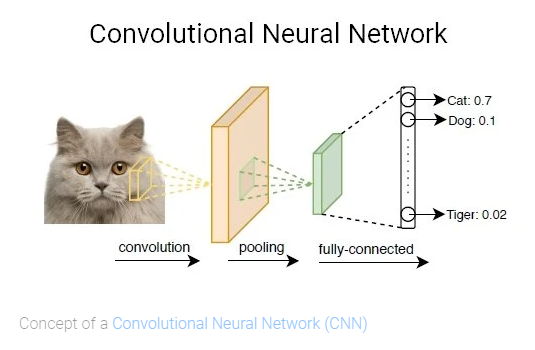

In [2]:
Image(filename='images/cnn-example-for-image-classification.png', width=800)

In [25]:
import tensorflow as tf
print(tf.__version__) #mostra versione attuale

2.8.0


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

In [27]:
batch_dim = 128
img_altezza = 200; img_ampiezza = 200 # reshape 200 x 200
train_dir = "data/dogs-vs-cats/dogs-vs-cats/train/"
val_dir = "data/dogs-vs-cats/dogs-vs-cats/test/"

**Data Augmentation**:
* ImageDataGenerator (attenzione al suo funzionamento, vedi [qui](https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/))
* flow_from_directory

Questo approccio è qui presentato sinteticamente, e sarà spiegato meglio nella sezione delle VGG.

In [28]:
# Data augmentation:
# primo passo: il costruttore (l'argomento 'rescale' ridimensiona i valori dei pixel nell'intervallo 0-1.)
train_image_generator = ImageDataGenerator(rescale=1./255) # crea immagini per training data
val_image_generator = ImageDataGenerator(rescale=1./255)   # crea immagini per test data

In [29]:
# carica i file dalle cartelle e li manda al generatore, con shuffle=True per mescolare i dati a caso
# dall'help: "Takes the path to a directory & generates batches of augmented data".

train_gen = train_image_generator.flow_from_directory(batch_size=batch_dim, directory=train_dir, shuffle=True, 
                                                      target_size=(img_altezza, img_ampiezza), class_mode='binary')
val_gen = val_image_generator.flow_from_directory(batch_size=batch_dim, directory=val_dir, 
                                                      target_size=(img_altezza, img_ampiezza), class_mode='binary')

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


In [30]:
print(type(train_gen))
print(type(val_gen))

<class 'keras.preprocessing.image.DirectoryIterator'>
<class 'keras.preprocessing.image.DirectoryIterator'>


In [20]:
# modello composto da tre convolution blocks con un max pool layer ognuno.
# connected layer completamente connesso con 512 unità con activation function tipo relu.
# poi il flattening (25x25x64 = 40.000).
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_altezza, img_ampiezza,3)), MaxPooling2D(), 
                                                                        # 16 filtri 3x3 e max pooling 2x2
    
    Conv2D(32, 3, padding='same', activation='relu'), MaxPooling2D(),   # 32 filtri 3x3 e max pooling 2x2
    
    Conv2D(64, 3, padding='same', activation='relu'), MaxPooling2D(),   # 64 filtri 3x3 e max pooling 2x2
    
    Flatten(), Dense(512, activation='relu'), Dense(1) ])               # appiattimento a 512 pixel

    # dall'help on-line:
    
    # Args:
    #   filters: Integer, the dimensionality of the output space (i.e. the number of
    #   output filters in the convolution).
    
    #   kernel_size: An integer or tuple/list of 2 integers, specifying the height
    #   and width of the 2D convolution window. Can be a single integer to specify
    #   the same value for all spatial dimensions.
    
    #   ...
    
    #   padding: one of `"valid"` or `"same"` (case-insensitive).
    #   "valid" means no padding. "same" results in padding with zeros evenly
    #   to the left/right or up/down of the input. When padding="same" and
    #   strides=1, the output has the same size as the input.
    #   
    #   activation: Activation function to use. If you don't specify anything, no
    #   activation is applied (see `keras.activations`).
    #
    #   4+D tensor with shape: `batch_shape + (channels, rows, cols)` if
    #   `data_format='channels_first'`
    #   or 4+D tensor with shape: `batch_shape + (rows, cols, channels)` if
    #   `data_format='channels_last'`.

    
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()  # crea modello, prepara per compilare, mostra le caratteristiche

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0

[Ecco](https://stackoverflow.com/questions/47312219/what-is-the-definition-of-a-non-trainable-parameter) cos'è un parametro *non-trainable* in *keras*.

Il fit del modello, ora. Sul mio PC richiede circa **75-85 sec. per epoca**.

In [21]:
import time
start = time.time()

# training della rete:
epoche = 3 # suggerite 25!
history = model.fit(train_gen,steps_per_epoch=tot_train // batch_dim,epochs=epoche,validation_data=val_gen,
                    validation_steps=tot_val // batch_dim)
                    # --> calcola loss ed accuracy sul training set in-synch e poi alla fine sul test test

end = time.time()
print(end - start)

Epoch 1/3
146/146 [==============================] - 158s 1s/step - loss: 0.7042 - accuracy: 0.6106 - val_loss: 0.5561 - val_accuracy: 0.6829
Epoch 2/3
146/146 [==============================] - 159s 1s/step - loss: 0.5288 - accuracy: 0.7178 - val_loss: 0.5142 - val_accuracy: 0.7388
Epoch 3/3
146/146 [==============================] - 159s 1s/step - loss: 0.4496 - accuracy: 0.7726 - val_loss: 0.4561 - val_accuracy: 0.7774
476.03300642967224


In [22]:
# tempo di esecuzione: 10-20 secondi
train_acc = history.history['accuracy']
print(train_acc)
print()
val_acc = history.history['val_accuracy']
print(val_acc)

[0.6105875372886658, 0.7177553772926331, 0.772631824016571]

[0.6828762888908386, 0.7388392686843872, 0.7774234414100647]


In [23]:
train_loss=history.history['loss']; print(train_loss)
val_loss=history.history['val_loss']; print(val_loss)

[0.7042233347892761, 0.5287583470344543, 0.44961681962013245]
[0.5560673475265503, 0.5141640901565552, 0.4560870826244354]


In [24]:
epoche_range = range(epoche)

Text(0.5, 1.0, 'Accuracy in Training e Test')

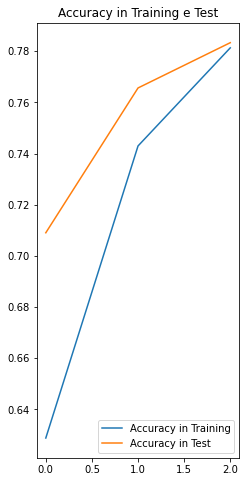

In [68]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epoche_range, train_acc, label='Accuracy in Training')
plt.plot(epoche_range, val_acc, label='Accuracy in Test')
plt.legend(loc='lower right')
plt.title('Accuracy in Training e Test')

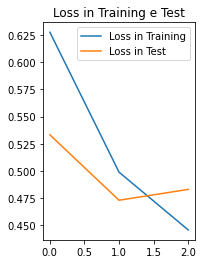

In [69]:
plt.subplot(1, 2, 2)
plt.plot(epoche_range, train_loss, label='Loss in Training')
plt.plot(epoche_range, val_loss, label='Loss in Test')
plt.legend(loc='upper right')
plt.title('Loss in Training e Test')
plt.show()

In [70]:
model.save('cd.h5') # esporta file con parametri del modello

### CNN (VGG) con *fine-tuning*
La classificazione del dataset cani-gatti con una VGG.<br>
Dal libro *Deep Learning for Computer Vision* di Jason Brownlee.

Ecco come sviluppare un modello di rete neurale convoluzionale **di base** per il set di dati cani vs gatti.<br><br>
Stabilisce una prestazione minima a cui tutti gli altri modelli possono essere confrontati, nonché un'architettura del modello che possiamo utilizzare come base per lo studio e il miglioramento.<br><br>

Un buon punto di partenza sono i **modelli VGG** ([vedi qui](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/)). Hanno infatti ottenuto le massime prestazioni nella competizione ILSVRC 2014, inoltre la loro struttura modulare dell'architettura è facile da capire e implementare. Per maggiori dettagli sul modello VGG, vedere il documento del 2015 "Reti convoluzionali molto profonde per il riconoscimento di immagini su larga scala".<br><br>

L'architettura prevede l'impilamento di strati convoluzionali con piccoli filtri 3×3 seguiti da uno strato di raggruppamento massimo. Insieme, questi strati formano un blocco e questi blocchi possono essere ripetuti (il numero di filtri in ciascun blocco viene aumentato con la profondità della rete: 32, 64, 128, 256 per i primi quattro blocchi del modello). Il riempimento viene utilizzato sui livelli convoluzionali per garantire che le forme di altezza e larghezza delle mappe delle caratteristiche di output corrispondano agli input.<br><br>

Possiamo esplorare questa architettura sul problema cani vs gatti e confrontare un modello con questa architettura con 1, 2 e 3 blocchi (cioè tre semplici modelli a confronto).<br><br>

Ciascun livello utilizzerà la funzione di attivazione ReLU ([qui](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)) e l'inizializzazione del peso He (le best practice, in genere). Ad esempio, un'architettura in stile VGG a 3 blocchi (un blocco è una sequenza *convolve/pool*), in cui ogni blocco ha un singolo livello convoluzionale ed un singolo livello di pooling, può essere definita in Keras nel seguente modo:<br>
[l'esecuzione di questo codice richiede circa **45 minuti (con la mia CPU e la mia RAM), circa 20 minuti con una moderna GPU**.]

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


C:\Users\Utente\AppData\Local\Temp/ipykernel_12192/333610795.py:132: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)


> 73.885


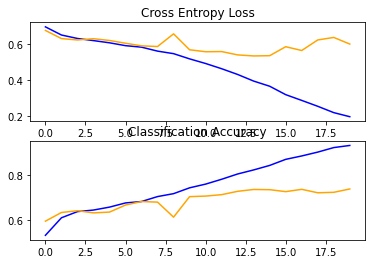

2823.7324912548065


In [163]:
# 1-vgg block baseline model for the dogs vs cats dataset

import time
start = time.time()

import random
random.seed(10)  # per garantire la riproducibilità dei risultati 
                 # (SGD infatti è stocastico, ma lo usa?!)

import sys
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
# from keras.optimizers import SGD      # non funziona, vedi stackoverflow
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# Servono diverse funzioni.

# a. define cnn model

# Creiamo una funzione denominata 'define_model()' che definisce un modello e lo restituisce pronto per essere inserito 
# nel set di dati. Questa funzione può essere personalizzata per definire diversi modelli di base, ad esempio versioni del 
# modello con 1, 2 o 3 blocchi di tipo VGG.
#
# Il modello utilizza per il fit l'algoritmo della discesa del gradiente stocastico, inizialmente con un tasso di 
# apprendimento conservativo di 0.001 e un momento di 0.9.

# --> Poichè si tratta di una classificazione binaria, che cioè richiede la previsione di un valore 0 o 1, utilizzeremo
# un livello di output con 1 nodo e un'attivazione sigmoidea; il modello verrà ottimizzato utilizzando la loss function
# della cross-entropy binaria. 

# Di seguito è dunque riportato un esempio della funzione 'define_model()'' per definire un modello di rete neurale 
# convoluzionale (per il problema cani vs gatti) con 1 blocco di tipo VGG.

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     input_shape=(200, 200, 3))) # un singolo layer convolutivo con 32 filtri 3x3 
    model.add(MaxPooling2D((2, 2)))              # e poi un layer max pool
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9) # il costruttore della classe SGD
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Questa funzione può essere chiamata con:
#    model = define_model()
# Vedi più avanti.

# b. plot diagnostic learning curves

# Ci serve quindi una funzione per creare un grafico della cronologia raccolta durante l'allenamento, memorizzata nella 
# directory "history", che è restituita dalla chiamata a fit_generator().

# La cronologia contiene l'accuratezza e la perdita (loss) del modello sul set di dati di addestramento e su quelli di test
# alla fine di ogni epoca. I grafici a linee di queste metriche ci permettono di capire se il modello è andato in 
# overfitting, underfitting o si è adattato abbastanza bene. 

# La seguente funzione 'summary_diagnostics()' sotto riportata prende la directory della cronologia e crea una singola 
# figura con un grafico a linee della perdita (loss) ed un altro per la precisione (accuracy). La figura viene quindi 
# salvata in un file con un nome file basato sul nome dello script. Ciò è utile se desideriamo valutare molte variazioni 
# del modello in file diversi e creare grafici lineari automaticamente per ciascuno.

def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')
    plt.show()

# c. run the test harness for evaluating a model.
# è il main.
# - definisce il modello;
# - prepara i dati;
# - fa il fit;
# - valuta le prestazioni predittive del modello (sui dati di test)

def run_test_harness():
    
    # c.1) define model (richiama cioè la funzione sopra definita)
    model = define_model()
    
    # c.2) create data generator
    # definisce un'istanza di ImageDataGenerator per ridimensionare i valori dei pixel nell'intervallo 0-1.
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    # c.3) prepare iterators
    
    # prepara gli iteratori sia per i dati di training che di test.
    
    # usa il metodo 'flow_from_directory()' della classe generatore di dati e crea un iteratore per ciascuna delle directory 
    # train/ e test/; occorre specificare che il problema di classificazione è binario; occorre anche indicare di caricare
    # le immagini con dimensione di 200×200 pixel (argomento 'target_size'); impostiamo la dimensione del batch a 64.
    train_it = datagen.flow_from_directory('data/dogs-vs-cats/dogs-vs-cats/train/',
                                          class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('data/dogs-vs-cats/dogs-vs-cats/test/',
                                          class_mode='binary', batch_size=64, target_size=(200, 200))
    
    # --> per conferma, questo metodo stampa alla fine la dimensione del training e del test dataset ed il
    #     numero di classi ("found XXXX images belonging to YYYY classes")
    
    # c.4) fit model
    
    # il fit del modello utilizzando l'iteratore del training test (train_it) e poi l'iteratore di test (test_it) per la
    # validazione del modello. 
    
    # occorre specificare il numero di step dei due iteratori; è il numero di lotti (batch) che comprendono un'epoca, e può
    # essere specificato tramite la lunghezza di ciascun iteratore (è il numero totale di immagini nella directory di
    # training ed in quella di test per la dimensione del batch (64).
    
    # il modello è fittato con 20 epoche, un numero piccolo ma sufficiente per verificare se il modello può apprendere il 
    # problema!
    history = model.fit(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    
    # c.5) evaluate model (l'accuratezza sulle immagini di test)
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))         # <-- il risultato principale della cella
    
    # c.6) learning curves
    
    # creazione del grafico della cronologia raccolta durante l'allenamento, memorizzata nella directory "history", che è 
    # restituita dalla chiamata a fit_generator().
    summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()


end = time.time()
print(end - start)

Esaminiamo i **due output** della cella (a parte il tempo di esecuzione).<br><br>
Data la natura stocastica di *SGD*, o per problemi di precisione numerica, **l'accuratezza di test (qui, quasi del 74%)**, può cambiare leggermente. Si può ri-eseguire la cella più volte e prendere la media, eventualmente.<br><br>
Esaminando il doppio grafico prodotto, possiamo vedere che il modello si è *sovra-adattato* (**overfit**) ai dati di training intorno alla epoca 12, dopo la quale infatti accuratezza e loss continuano a migliorare solo sul training set e non più sul test set. (in blu il training, in arancione il test dataset).

La seguente rete 2-VGG fitta sul mio PC in circa **80 minuti**.

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 76.440


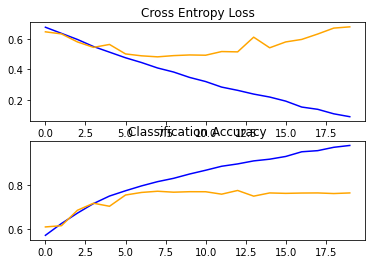

4723.500696182251


In [164]:
# 2-vgg block baseline model for the dogs vs cats dataset.
# cioè due sequenze convolve/pool, ora.
# il secondo 'convolve' usa 64 filtri (anzichè 32).

import time
start = time.time()

import random
random.seed(10)  # per garantire la riproducibilità dei risultati 
                 # (SGD infatti è stocastico, ma lo usa?!)
import sys
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.show()

# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow_from_directory('data/dogs-vs-cats/dogs-vs-cats/train/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('data/dogs-vs-cats/dogs-vs-cats/test/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

end = time.time()
print(end - start)

Questo modello a due blocchi fornisce un'accuratezza di test del **76%**, che è un pò migliore del modello ad 1 blocco solo.<br><br>
Dai due plot sembra anche ora che il modello sia andato in overfit, un pò prima questa volta (intorno all'epoca 8). Ciò può essere dovuto alla maggiore *capacity* del modello.<br><br>
E' ragionevole aspettarsi che questo trend continui, e che perciò un modello a 3 blocchi, cioè con tre sequenze *convolve/pool* successive, vada in overfit ancora prima.

In [168]:
# 3-vgg block baseline model for the dogs vs cats dataset
# cioè tre sequenze convolve/pool.
# il terzo 'convolve' usa 128 filtri (anzichè 32 o 64).

import sys
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
# from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = datagen.flow_from_directory('data/dogs-vs-cats/dogs-vs-cats/train/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('data/dogs-vs-cats/dogs-vs-cats/test/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
> 78.486


C'è ora un ulteriore miglioramento dell'accuratezza di test (**78%**).<br><br>
Ora, come previsto, il modello va in overfit ancora prima (intorno all'epoca 5 o 6).<br><br>
I risultati di questi 3 modelli VGG suggeriscono che, per la chiara <u>tendenza all'overfit</u> dei modelli (sempre prima!), sia opportuna una qualche forma di regolarizzazione; ad esempio: il *weight decay* (vedi [qui](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab) e [qui](https://stats.stackexchange.com/questions/29130/difference-between-neural-net-weight-decay-and-learning-rate)), la *data augmentation* (vedi le slide "Introduzione alle CNN"), od il *drop-out*.<br><br>
Tutte e tre queste tecniche dovrebbero rallentare il tasso di apprendimento del modello durante il training e quindi prevenire l'verfit.<br><br>
Utilizziamo la tecnica del *drop-out*, applicato al modello a 3 blocchi, con <u>50 epoche</u> (anzichè 20) per dare al modello più spazio di miglioramento.

La regolarizzazione per abbandono (*drop-out*) è un modo computazionalmente economico per regolarizzare una rete neurale profonda.<br><br>
Il dropout funziona rimuovendo probabilisticamente (cioè appunto *dropping out*) gli input ad un livello, che possono essere variabili di input (del campione di dati) od attivazioni da un livello precedente. Ha l'effetto
di simulare un gran numero di reti con strutture (di rete) molto diverse e, a sua volta,
rendendo i nodi della rete generalmente più robusti agli input.<br><br>
Per maggiori informazioni sul *drop-out*, si veda [questo post](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/).<br><br>
In genere, si può applicare una piccola quantità di dropout dopo ogni blocco VGG, ed una quantità di dropout maggiore verso la fine del modello (nei livelli densi che classificano l'immagine).<br><br>
In questo caso, applichiamo un dropout del 20% dopo ogni blocco VGG ed un dropout del 50% alla fine. 

In [172]:
# FULL baseline model with dropout for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
# from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterator
    train_it = datagen.flow_from_directory('data/dogs-vs-cats/dogs-vs-cats/train/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = datagen.flow_from_directory('data/dogs-vs-cats/dogs-vs-cats/test/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


KeyboardInterrupt: 

Esaminando le curve di apprendimento, vediamo che il droput <u>ha avuto effetto</u> sia sul training set che sul test set.<br><br>
L'overfit è stato **ridotto o ritardato**, sebbene le prestazioni inizino a fermarsi verso la fine delle epoche.<br><br>
Questi risultati suggeriscono che un ulteriore aumento del numero delle epoche può essere utile, come anche (forse) un tasso di dropout leggermente superiore (in aggiunta all'aumento del numero di epoche).

L'aumento dei dati dell'immagine (**data augmentation**) è una tecnica che può essere utilizzata per espandere artificialmente le dimensioni di un dataset di training creando <u>versioni modificate delle immagini</u> tramite:
* capovolgimenti orizzontali, 
* capovolgimenti verticali, 
* rotazioni, 
* zoom
* ecc.
<br>

L'allenamento di modelli di rete neurale su **maggiori quantità di righe** (immagini, in questo caso) offre infatti diversi vantaggi:
* può permettere di costruire modelli più "capaci"
* permette di **variare** le immagini in input, aumentando le capacità di fit dei modelli e di generalizzazione a nuove immagini
* può anche fungere da tecnica di **regolarizzazione**, aggiungendo <u>rumore</u> ai dati di training ed incoraggiando il modello ad apprendere le caratteristiche <u>invarianti</u> rispetto alla loro posizione nell'input.<br><br>

Le modifiche delle immagini (capovolgimenti, rotazioni, zoom) sono passate come argomenti alla classe *ImageDataGenerator* (per il training set).<br><br>
La *data augmentation* <u>non</u> deve essere utilizzata con i dati di test, perchè vogliamo le prestazioni predittive del modello su immagini non-moficate. Ciò richiede due istanze separate di *ImageDataGenerator*, una per il training set ed una per il test set, e quindi due iteratori separati (creati dai rispettivi generatori di dati).

In [165]:
# FULL baseline model with data augmentation for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
# from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generators 
    # - shift casuali (orizzontali e verticali) del 10%)
    # - rotazioni casuali orizzontali (--> immagine a specchio)
    # le immagini del training set e del test set hanno i pixel scalati in modo uguale.
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
        width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    train_it = train_datagen.flow_from_directory('data/dogs-vs-cats/dogs-vs-cats/train/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    test_it = test_datagen.flow_from_directory('data/dogs-vs-cats/dogs-vs-cats/test/',
        class_mode='binary', batch_size=64, target_size=(200, 200))
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

ImportError: cannot import name 'SGD' from 'keras.optimizers' (C:\Users\Utente\anaconda3\lib\site-packages\keras\optimizers.py)

Grazie alla *data augmentation* le prestazioni predittive del modello sono salite dall'80% all'**85%** circa.<br><br>
Guardando le curve di apprendimento, il modello sembra capace di ulteriori miglioramenti, sia sul training che sul test set, anche <u>alla fine delle epoche</u>. Ciò suggerisce di sperimantare il fit del modello con un numero di epoche ancora superiore, ad esempio 100 oppure più ancora.

**<u>SINTESI</u>**<br>
Abbiamo esplorato due diversi miglioramenti al modello di base (una VGG con 3 ripetizioni *convolve/pool*).<br>
I risultati sono i seguenti (attenzione: ci può essere una certa varianza in questi risultati data la natura stocastica dell'algoritmo):
* **modello base + regolarizzazione tramite *dropout*: 85.9%**
* **modello base + regolarizzazione tramite *data augmentation*: 88.2%**


Come sospettato, l'uso di tecniche di regolarizzazione rallenta la progressione dell'apprendimento e riduce l'overfitting, con conseguente miglioramento delle prestazioni sul set di dati di test.<br><br>
È probabile che la combinazione di entrambi gli approcci (*dropput + data augmentation*), insieme ad un ulteriore aumento del numero di epoche di addestramento, si traducano in ulteriori miglioramenti della capacità predittiva del modello.<br><br>
Potrebbero infine essere esplorate altri tecniche di regolarizzazione come il decadimento del peso  (*weight decay*) e l'interruzione anticipata (*early stopping*).<br><br>
Infine, potrebbe valere la pena di esplorare l'effetto (sulle prestazioni predittive del modello) di  differenti velocità di apprendimento (*learning rate*) o dell'ottimizzatore adattivo *adam*.

Un modello **MIGLIORE** di questi 3, comunque, è il **VGG-16**, che è <u>PRE-allenato sul dataset *ImageNet*</u>.<br><br>
E' un modello VGG-16 a 16 livelli totali (13 convolutivi). E' composto infatti da una prima parte di 13 livelli convolutivi ed una parte finale di livelli densi con una previsione binaria.<br><br>
All'epoca (il 2014), il VGG-16 risultò essere il miglior classificatore di immagini di *ImageNet* in una gara di classificazione.<br><br>
Inoltre, VGG-16 è spesso usato a scopi didattici per la sua architettura semplice ed elegante.<br><br>
VGG-16 è allenato su sole 10 epoche perchè non richiede tanto tempo di training perchè solo i tre livelli finali hanno parametri allenabili.<br><br>
VGG-16 si aspetta immagini 224x224, centrate sulle medie di ogni canale RGB di *ImageNet*.<br><br>
E' riportata qui sotto l'architettura di VGG-16:

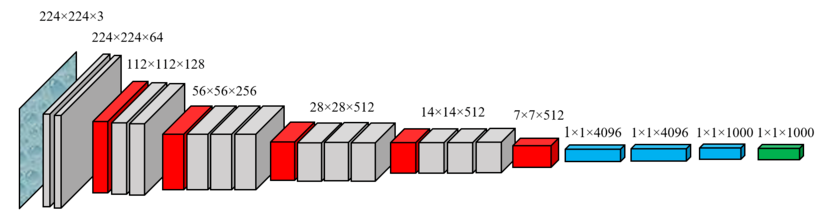

In [169]:
Image(filename='images/VGG_net_architecture.png', width=800)

In [ ]:
# vgg16 model used for transfer learning on the dogs and cats dataset
import sys
from matplotlib import pyplot
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
# from keras.optimizers import SGD

from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3)) # il modello pre-allenato
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
    # specify imagenet mean values for centering
    datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterator
    train_it = datagen.flow_from_directory('data/dogs-vs-cats/dogs-vs-cats/train/',
        class_mode='binary', batch_size=64, target_size=(224, 224))
    test_it = datagen.flow_from_directory('data/dogs-vs-cats/dogs-vs-cats/test/',
        class_mode='binary', batch_size=64, target_size=(224, 224))
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

Variazioni stocastiche ed errori numerici a parte, VGG-16 ha un'accuratezza di test del **97%**, abbastanza impressionante e molto superiore ai nostri tre modelli custom (prima definiti e testati), <u>ovviamente</u>.<br><br>
Esaminando le curve di apprendimento, si nota che il modello si adatta al training set rapidamente. Non mostra overfit pronunciato, sebbene probabilmente un fine-tuning dei pesi e/o una regolarizzazione potrebbero essere utili.

Perchè abbiamo allenato e testato questi modelli? **Per fare previsioni!**<br><br>
In genere, una volta che si è individuato il modello migliore, per non sprecare immagini lo si fitta sull'intero dataset (train + test). Tuttavia qui non abbiamo le etichette di test. Fittiamo il modello su tutto il training set e poi lo salviamo.

In [ ]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
# create directories
dataset_home = 'finalize_dogs_vs_cats/'
# create label subdirectories
labeldirs = ['dogs/', 'cats/']
for labldir in labeldirs:
    newdir = dataset_home + labldir
    makedirs(newdir, exist_ok=True)
# copy training dataset images into subdirectories
src_directory = 'dogs-vs-cats/train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    if file.startswith('cat'):
        dst = dataset_home + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + 'dogs/'  + file
        copyfile(src, dst)

In [ ]:
# save the final model to file to the WHOLE training set
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# run the test harness for evaluating a model
def run_test_harness():
# define model
    model = define_model()
    # create data generator
    datagen = ImageDataGenerator(featurewise_center=True)
    # specify imagenet mean values for centering
    datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterator
    train_it = datagen.flow_from_directory('finalize_dogs_vs_cats/',
        class_mode='binary', batch_size=64, target_size=(224, 224))
    # fit model
    model.fit(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=0)
    # save model
    model.save('final_model.h5')

# entry point, run the test harness
run_test_harness()

Dopo l'esecuzione di questa cella sul nostro disco c'è un file di 81 MB.<br><br>
Finalmente le previsioni.<br><br>
Il modello assume che le nuove immagini siano a colori e siano state segmentate in modo che ogni immagine contenga almeno un cane od un gatto.<br><br>
Visualizziamo un'immagine di esempio dal set di test. Non ha etichetta, ovviamente. E' un cane<br><br>
E facciamo la previsione (1 per cane, 0 per gatto). Correttamente il modello prevede 1.

In [ ]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(224, 224))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 224, 224, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

# load an image and predict the class
def run_example():
    # load the image
    img = load_image('sample_image.jpg')
    # load model
    model = load_model('final_model.h5')
    # predict the class
    result = model.predict(img)
    print(result[0])

# entry point, run the example
run_example()

**Possibili miglioramenti finali** (sempre si può migliorare):
* regolarizzazione del modello base con altre tecniche? (ad esempio altre percentuali di *dropout* oppure differenti *data augmentation*; *weight decay*?)
* tuning del *learning rate*
* altri modelli pre-allenati? ad esempio *Inception* oppure *ResNet*.

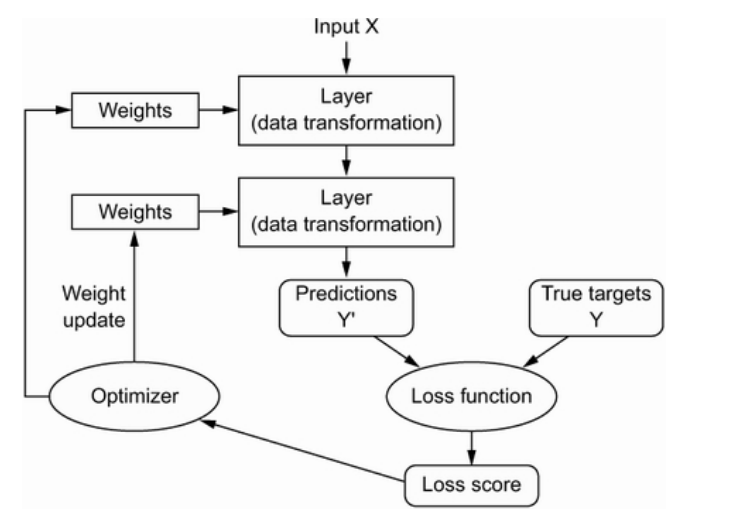

In [170]:
Image(filename='images/relationship_btw_cnn_parts.png', width=1200) # le relazioni tra la rete, i livelli, la funzione di 
                                                                    # loss e l'ottimizzatore


## MNIST
Un classico problema: il **riconoscimento automatico di cifre scritte a mano**. Non è banale ed è un benchmark ormai classico.<br><br>
Con una rete MLP (non fatto in questo corso, per semplificare) si ottiene un'accuratezza di test dell'**89%**. [Ma si può arrivare sino al 97.8% - Chollet] <br><br>
In molte applicazioni *mission-critical*, come ad esempio la lettura delle cifre di un IBAN bancario scritto a mano su un documento, questa percentuale è troppo bassa.<br><br>

Vediamo se una rete CNN può fare meglio di una rete MLP.<br><br>
Sono possibili diverse architetture CNN per affrontare questo problema.<br><br>
Il seguente modello NN accetta immagini MNIST **rimodellate in vettori a 784 dimensioni** (nel formato X_train, X_valid o X_test) per le 10 classi intere (cifre 0-9). Il **livello nascosto è qui composto da 50 nodi**. Inoltre, per semplificare le cose, utilizziamo una funzione di attivazione **sigmoide** sia dopo il primo livello nascosto e che per il livello di output.

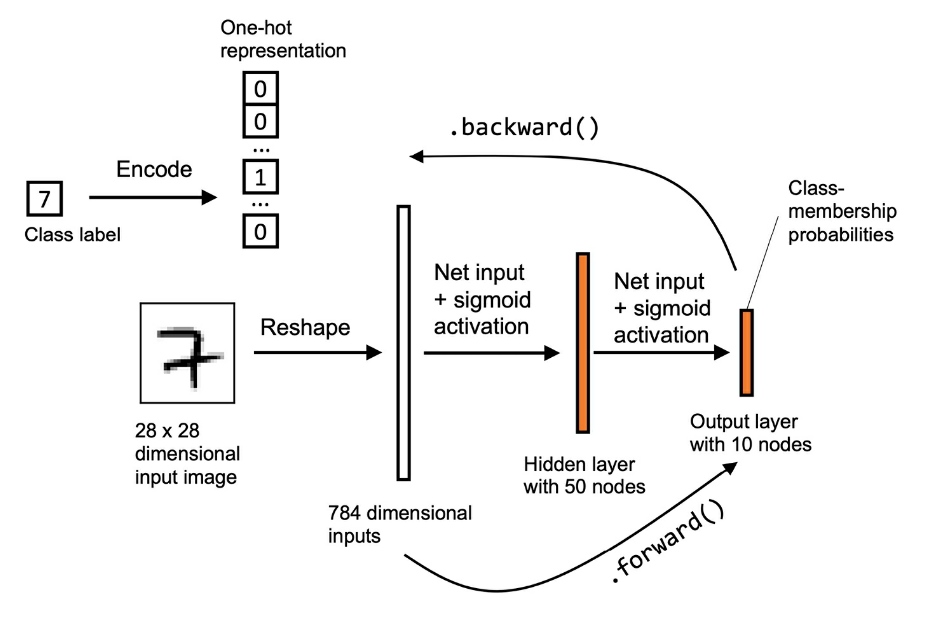

In [160]:
Image(filename='images/MNIST_NN_architecture.png', width=1200) # una possibile architettura

Useremo questa architettura, una *convnet* di base composta da uno *stack* (*pila*) di livelli **Conv2D** e **MaxPooling2D**:
* gli input sono immagini in una scala di grigi 28x28; 
* poichè, dunque, il canale colore è 1, la dimensione del tensore di input è: ***batch-size* x28x28x1** (dove *batch-size* rappresenta il numero di immagini in input)
* le immagini in input attraversano **due livelli convoluzionali** che hanno una dimensione del kernel (la matrice dei pesi *w*) di 5x5. La prima convoluzione ha 32 *feature map* di output e la seconda ha 64 *feature map* di output.
* ogni livello di convoluzione è seguito da un livello di sottocampionamento di tipo *max-pooling* 2x2. 
* quindi un livello pienamente connesso (*fully connected*) passa l'output ad un secondo livello pienamente connesso, che funge da livello finale di output *softmax*. 

Ecco il disegno dell'architettura:

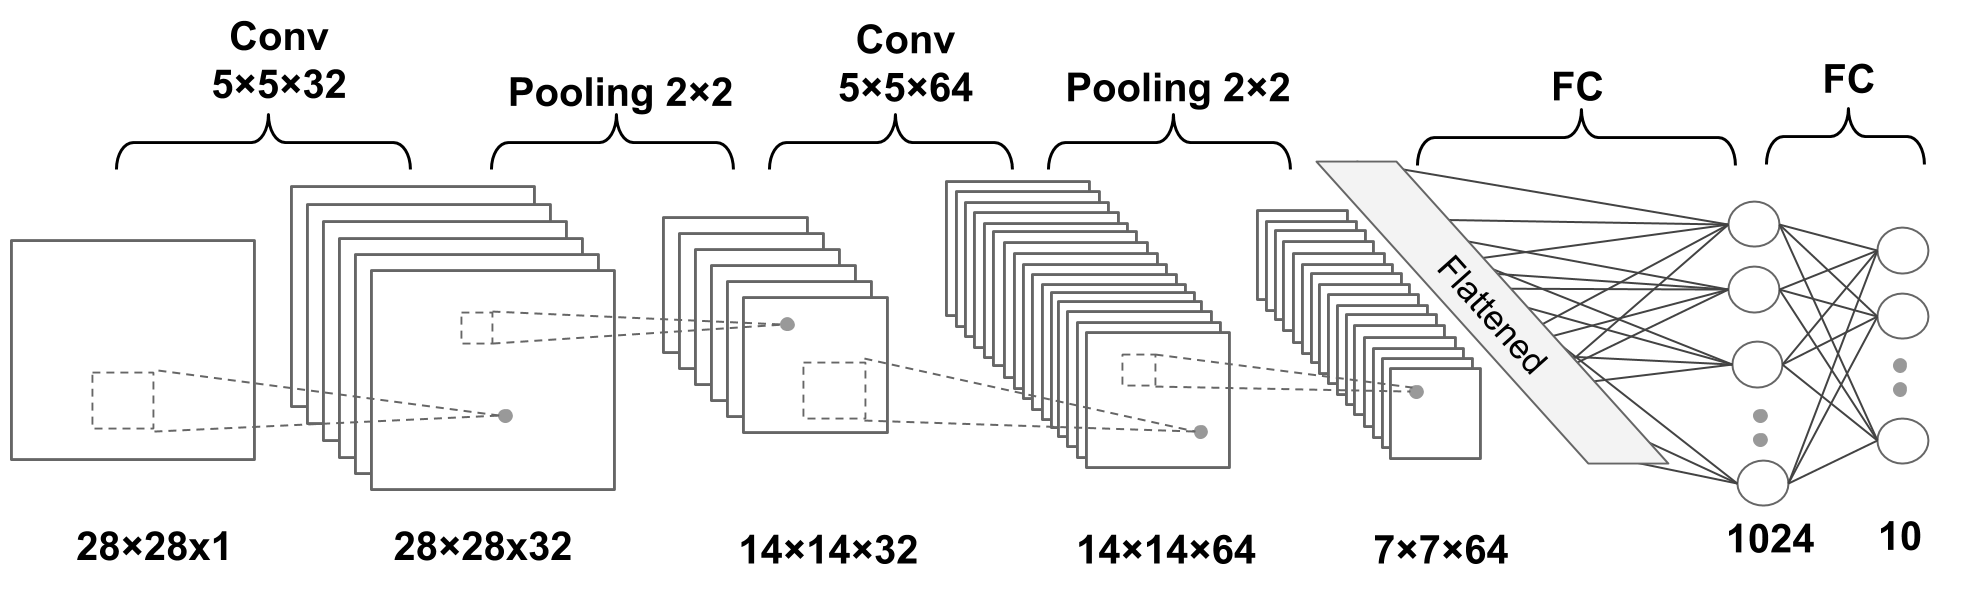

In [71]:
Image(filename='images/15_12.png', width=1200)   # l'architettura che useremo

Una *convnet*, in generale, ha in input dei tensori della forma (*shape*): (*image_height*, *image_width*, *image channel*), senza contare la dimensione *batch*.<br><br>
Come si vede dalla figura soprastante, solo **una parte dei pixel** (unità o nodi) del livello di input sono connessi con il livello successivo, a differenza delle reti MLP, dove i livelli sono *densi* (ovvero *pienamente connessi*), cioè tutti i nodi (pixel) di un livello sono connessi con tutti i nodi del livello successivo.<br><br>
L'output di ogni livello *Conv2D* e di ogni livello *MaxPooling2D* è un **tensore di rango 3 di forma (*height,width,channel*)**, anche conosciuto come **feature map**. Le prime due dimensioni sono **spaziali**, la terza (il canale) rappresenta la profondità della rete.<br><br>
Le dimensioni *height* e *width* della *feature map* tendono a diminuire mano a mano che il modello diventa profondo.<br><br>
Il numero di canali (di tipo *colore* per il livello di input, di tipo *filtro* per i livelli successivi) è controllato tramite **il primo** argomento passato ai livelli *Conv2D* (qui, 1 e poi 32 e 64). Nel caso delle immagini del dataset MNIST, il canale di tipo colore ha profondità 1 (perchè sono immagini su una scala di grigi). <br><br>
Gli ultimi due livelli sono i classici livelli pienamente connessi (tutti i pixel con tutti i pixel). Sono i **classificatori**. Siccome, come sappiamo, questi livelli elaborano vettori (in input), occorre prima che *appiattiamo* i tensori 3D (le *feature map*) in vettori 1D.<br><br>
L'ultimo livello denso (cioè, pienamente connesso) fa la classificazione a 10 classi con la funzione di attivazione *softmax*.

La **differenza principale** tra <u>un livello convoluzionale ed un livello denso (pienamente connesso)</u> è la seguente:
* i livelli densi imparano pattern **globali** presenti nello spazio della feature map in input; per esempio, per le cifre del dataset MNIST o comunque per immagini, i pattern che coinvolgono TUTTI i pixel.<br><br>
* i livelli convoluzionali, invece, imparano pattern **locali**; nel caso di immagini, i pattern trovati in piccole finestre 2D di pixel.

<u>Un esempio</u>: un livello convoluzionale, dopo aver imparato un certo pattern (ad esempio nell'angolo sx alto dell'immagine), è in grado di riconoscerlo **ovunque all'interno dell'immagine**, ad esempio anche nell'angolo dx basso; un livello denso, al contrario, non sarebbe in grado di riconoscere il pattern in un'altra zona dell'immagine.<br><br>
Grazie a questa proprietà dei livelli convulozionali, una CNN ha bisogno di **meno immagini** rispetto ad altri modelli, ed anche per questa ragione rappresenta il *gold standard* nella *computer vision*.   

Le dimensioni dei tensori dei livelli di questa rete sono le seguenti:
* Input: [*batch-size* x 28 x 28 x 1]    - la forma delle immagini di MNIST è infatti [28,28,1]
* Conv_1: [*batch-size* x 28 x 28 x 32]
* Pooling_1: [*batch-size* x 14 x 14 x 32]
* Conv_2: [*batch-size* x 14 x 14 x 64]
* Pooling_2: [*batch-size* x 7 x 7 x 64]
* FC_1: [*batch-size* x 1024]
* FC_2 e softamx: [*batch-size* x 10]

Per i livelli convoluzionali, usiamo *strides = 1*, in modo tale che le dimensioni di input siano preservate nelle *feature map* risultanti. Per i livelli di pooling, utilizziamo *strides = 2* per sottocampionare l'immagine e ridurre le dimensioni delle *feature map* di output. Implementeremo questa rete utilizzando l'API ad oggetti di *TensorFlow Keras*.

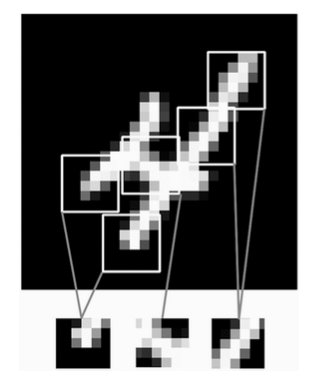

In [112]:
Image(filename='images/conv_oper_on_MNIST.png', width=400)   # le immagini (qui, un 4) possono essere suddivise in pattern
                                                             # locali come bordi, forme, strutture, ecc dalla operazione
                                                             # di convoluzione.

Cosa sono gli ***strides***?<br><br>
Il filtro viene spostato sull'immagine da sinistra a destra, dall'alto verso il basso, con un cambio di colonna di un pixel sui movimenti orizzontali, quindi un cambio di riga di un pixel sui movimenti verticali.<br><br>
La quantità di movimento tra le applicazioni del filtro all'immagine di input viene definita *stride* (letter. "falcata") ed è quasi sempre simmetrica nelle dimensioni di altezza e larghezza.<br><br>
L'andatura predefinita (le falcate) in due dimensioni sono (1,1) per il movimento in altezza e in larghezza, eseguito quando necessario. Questa impostazione predefinita funziona bene nella maggior parte dei casi.<br><br>
La falcata può essere modificata, il che ha un effetto sia sul modo in cui il filtro viene applicato all'immagine sia, a sua volta, sulla dimensione della *feature map* risultante.
Ad esempio, sempre in 2D, la falcata può essere modificata in (2,2). Ciò ha l'effetto di spostare il filtro di due pixel verso destra per ogni movimento orizzontale del filtro e di due pixel verso il basso per ogni movimento verticale del filtro durante la creazione della *feature map*.<br><br>
Più info sulle *strides* [qui](https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/).

Come già visto, ci sono due modi per **caricare** i dataset disponibili nel modulo *tensorflow_datasets*.<br><br>
Un approccio si basa su un <u>processo in tre passi</u>, un metodo più semplice utilizza una funzione chiamata *load*, che racchiude questi tre passaggi. Qui useremo il primo metodo.<br><br> I tre passi per caricare il set di dati MNIST sono i seguenti:

In [38]:
# caricamentro dei dati MNIST

mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
print(datasets.keys())
mnist_train_orig, mnist_test_orig = datasets['train'], datasets['test']

dict_keys(['train', 'test'])


Il set di dati MNIST viene fornito con uno **schema di partizionamento** del set di dati di train  e test pre-definito; qui vogliamo tuttavia creare anche un dataset intermedio di convalida dal training.<br><br>
Si noti che nel terzo passo, utilizziamo un argomento facoltativo (*shuffle_files = False*) nel metodo *.as_dataset().* Ciò impedisce il rimescolamento iniziale, necessario poiché vogliamo dividere il set di dati di training in due parti: un set di dati di training più piccolo e un set di dati di convalida. (Nota: se la mescolatura iniziale non è stata disattivata, si verificherebbe un rimescolamento del set di dati ogni volta che recuperiamo un mini-batch di dati.)

In [39]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20      # si può diminuire questo valore in demo (per velocizzarla)

In [40]:
# split dei dati (con shuffling):
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0, 
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

Ora siamo pronti ad implementare la CNN sopra descritta.<br><br>
Utilizziamo la classe *Sequential* di *keras* per **impilare** livelli differenti: convoluzione, pooling e dropout, nonché i livelli completamente connessi (densi).<br>
L'API dei livelli Keras fornisce classi per ciascuno di questi livelli: 
* *tf.keras.layers.Conv2D* per un livello di convoluzione bidimensionale; 
* *tf.keras.layers.MaxPool2D* e *tf.keras.layers.AvgPool2D* per il sottocampionamento (*max-pooling* e *average-pooling*);
* *tf.keras.layers.Dropout* per la regolarizzazione tramite dropout.

### Configurare i livelli della CNN con Keras

La costruzione di un livello con la classe ***Conv2D*** richiede di specificare il numero di filtri di output (che equivale al numero di *feature map* di output) e le dimensioni del kernel. Inoltre, ci sono argomenti opzionali: i più comunemente usati sono gli *strides* (con un valore predefinito di 1 in entrambe le dimensioni x, y) ed il *padding*, che può essere *same* oppure *valid*. Ulteriori parametri di configurazione sono disponibili [qui](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2D). Ricordiamo che, di solito, quando leggiamo un'immagine, la dimensione predefinita per i canali è l'ultima dimensione dell'array tensoriale. Questo è chiamato il formato "NHWC", dove N sta per il numero di immagini all'interno del batch, H e W stanno rispettivamente per altezza e larghezza, e C sta per canali. La classe Conv2D presuppone che gli input siano nel formato NHWC per impostazione predefinita. (Altri software, ad esempio PyTorch, utilizzano invece un formato NCHW.) Tuttavia, se ci imbattiamo in alcuni dataset i cui canali sono posizionati nella prima dimensione (la prima dimensione dopo la dimensione batch o la seconda dimensione considerando la dimensione batch), è necessario scambiare gli assi nei dati per spostare i canali nell'ultima dimensione. Oppure, un modo alternativo per lavorare con un input formattato NCHW consiste nell'impostare *data_format = "channels_first"*. Dopo che il livello è stato costruito, esso può essere chiamato fornendo un tensore quadridimensionale, con la prima dimensione riservata a un lotto di righe; a seconda dell'argomento *data_format*, la seconda o la quarta dimensione corrispondono al canale, e le altre due dimensioni sono le dimensioni spaziali.<br><br>
Come mostrato nell'architettura del nostro modello CNN, ogni livello di convoluzione è seguito da un livello di **pooling** per il sottocampionamento (riducendo la dimensione delle *feature map*). Le classi *MaxPool2D* es *AvgPool2D* costruiscono rispettivamente i livelli *max-pooling* ed *average-pooling*. L'argomento *pool_size* determina la dimensione della finestra (o del vicinato) che verrà utilizzata per calcolare le operazioni massimo o media. Inoltre, si può usare l'argomento *strides* per configurare il livello di pooling, come detto in precedenza.<br><br>
Infine, la classe ***Dropout*** costruisce il livello di dropout per la regolarizzazione, con l'argomento *rate* per determinare la probabilità di eliminare le unità di input durante l'allenamento. Quando si chiama questo livello, il suo comportamento può essere controllato tramite un argomento chiamato *training*, che serve a specificare se questa chiamata è effettuata durante il training o durante la previsione. <br><br>
Ecco un *recap* delle classi con gli argomenti discussi:

 * **Conv2D:** `tf.keras.layers.Conv2D`
   * `filters`
   * `kernel_size`
   * `strides`
   * `padding`
   
   
 * **MaxPool2D:** `tf.keras.layers.MaxPool2D`
   * `pool_size`
   * `strides`
   * `padding`
   
   
 * **Dropout** `tf.keras.layers.Dropout2D`
   * `rate`

### Costruire la CNN con *Keras*
Ora possiamo costruire il modello CNN che è stato mostrato nella figura precedente. Nel codice seguente, useremo la classe *Sequential* ed aggiungeremo (impileremo) i livelli di convolution e pooling.<br><br>
Iniziamo con lo *stack* dei due livelli di convoluzione.

In [79]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))
    
model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

Per ogni livello convoluzionale, abbiamo usato un kernel *5x5* e l'imbottitura (*padding*) 'same'. Come detto prima,  l'utilizzo di *padding ='same'* preserva le dimensioni spaziali (dimensioni verticali e orizzontali) delle *feature map*  in modo tale che gli input e gli output abbiano la stessa altezza e larghezza (e il numero di canali può differire solo in termini di numero di filtri utilizzati).<br><br>
I livelli *max-pooling* con *pooling_size = 2x2* e *strides=2* riducono della metà le dimensioni spaziali. (Si noti che se l'argomento *strides* non è specificato in MaxPool2D, per default esso  è impostato uguale al *pooling size*).<br><br>
Sebbene in questa fase potremmo ancora calcolare manualmente la dimensione delle *feature map*, usiamo il comodo metodo dell'API Keras per calcolarlo:

In [42]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

Fornendo la forma di input (*input_shape*) come tupla specificata (in questo esempio), il metodo *compute_output_shape* ha calcolato che l'output abbia una forma (16, 7, 7, 64), che significa:
* le *feature map* hanno 64 canali (il numero di filtri)
* una dimensione spaziale di 7x7   (la riduzione delle dimensioni spaziali delle immagini, operata dai 2 livelli
di max-pooling, da 28x28 (iniziale) a 14x14 a 7x7. 

La prima dimensione corrisponde alla dimensione batch, per la quale abbiamo usato arbitrariamente il valore 16. Avremmo potuto usare invece 'None', cioè *input_shape =( None, 28, 28, 1)*. [Cioè elaborazione di una singola immagine per volta]<br><br>
Il livello successivo che vogliamo aggiungere è un livello denso (o "completamente connesso") che implementa un classificatore "on the top" dei livelli convoluzionali e di pooling. L'input di questo livello deve avere rango 2, cioè forma *batch-size x input_units*. Pertanto, è necessario appiattire (*flatten*) l'output dei precedenti livelli così da soddisfare questo requisito (dei livelli densi):

In [43]:
model.add(tf.keras.layers.Flatten())
    
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

Come il risultato di questo metodo (*compute_output_shape*) indica, le dimensioni di input del livello denso sono impostate correttamente.<br<<br>
Aggiungiamo quindi i due livelli densi con un livello di *dropout* in mezzo:

In [44]:
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

L'ultimo livello pienamente connesso, denominato 'fc_2', ha 10 unità di output per le 10 etichette di classe (com'è appunto il set di dati MNIST). Inoltre, abbiamo utilizzato l'attivazione *softmax* per ottenere le <u>probabilità</u> di appartenenza alla classe di ciascuna immagine di input. Se le classi si escludono a vicenda (cioè un'immagine di training  può appartenere ad una sola classe, ed è così in questo dataset), le probabilità delle 10 classi per ogni immagine sommano ad 1.<br><br>
Quale *loss* possiamo usare qui? Per una classificazione multiclasse con etichette intere (com'è questa), conviene utilizzare la *SparseCategoricalCrossentropy*. Diverso sarebbe se le classi fossero classificate con il metodo *one-hot encoding*.<br><br>
Le celle seguenti chiamano il metodo *build()* per la creazione delle *late variable* e poi compilano il modello:

In [45]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))

model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 10])

In [81]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 14, 14, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 64)        51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 7, 7, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 flatten_2 (Flatten)         (None, 3136)              0         
                                                                 
 fc_1 (Dense)                (None, 1024)             

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

Ed ora il **fit** del modello.<br><br>
NB. L'utilizzo di metodi specifici per l'addestramento e la valutazione (come *evaluate* e *predict*) imposta automaticamente la modalità del livello *drop-out* e ridimensiona (*rescale*) in modo appropriato  le unità nascoste. Non dobbiamo quindi preoccuparci di questo aspetto!<br><br>

In [47]:
import time
start_time = time.time()

# tempo di esecuzione sul mio PC: 10 minuti circa.
history = model.fit(mnist_train, epochs=NUM_EPOCHS, 
                    validation_data=mnist_valid, 
                    shuffle=True)

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/20
782/782 [==============================] - 32s 40ms/step - loss: 0.1372 - accuracy: 0.9570 - val_loss: 0.0466 - val_accuracy: 0.9861
Epoch 2/20
782/782 [==============================] - 32s 41ms/step - loss: 0.0453 - accuracy: 0.9857 - val_loss: 0.0389 - val_accuracy: 0.9880
Epoch 3/20
782/782 [==============================] - 32s 41ms/step - loss: 0.0289 - accuracy: 0.9907 - val_loss: 0.0412 - val_accuracy: 0.9876
Epoch 4/20
782/782 [==============================] - 32s 41ms/step - loss: 0.0224 - accuracy: 0.9932 - val_loss: 0.0354 - val_accuracy: 0.9903
Epoch 5/20
782/782 [==============================] - 32s 41ms/step - loss: 0.0175 - accuracy: 0.9947 - val_loss: 0.0479 - val_accuracy: 0.9878
Epoch 6/20
782/782 [==============================] - 32s 41ms/step - loss: 0.0143 - accuracy: 0.9954 - val_loss: 0.0406 - val_accuracy: 0.9898
Epoch 7/20
782/782 [==============================] - 32s 40ms/step - loss: 0.0132 - accuracy: 0.9956 - val_loss: 0.0448 - val_accuracy:

Possiamo ora monitorare i progressi dell'apprendimento sulle 20 epoche visualizzando le cosiddette *curve di apprendimento*. A questo scopo utilizziamo il set di dati di convalida (che abbiamo creato prima):

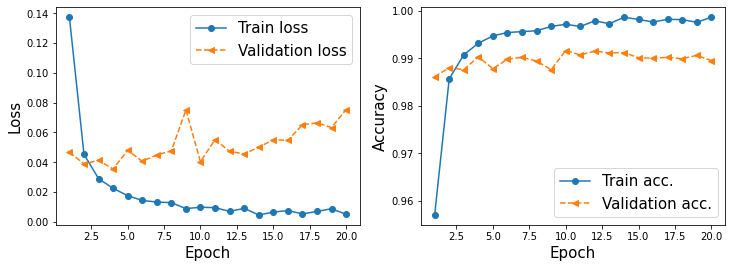

In [48]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/15_12.png', dpi=300)
plt.show()

In [49]:
# Per valutare il modello (che si è prima fittato) sui dati di test, si usa il metodo *.evaluate*:
test_results = model.evaluate(mnist_test.batch(20))
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

500/500 [==============================] - 2s 4ms/step - loss: 0.0549 - accuracy: 0.9927

Test Acc. 99.27%


Come si vede, il modello CNN raggiunge un'**accuratezza del 99,39%**, molto superiore all'89% ottenibile utilizzando lo stimatore *DNNClassifier*.<br><br>
Infine, possiamo ottenere i risultati della previsione sotto <u>forma di probabilità di appartenenza alla classe</u> e convertirli in etichette previste, utilizzando la funzione *tf.argmax* (che trova la classe con la probabilità massima). Lo facciamo con un batch di 12 immagini e ne visualizziamo le etichette di input (effettive) e previste:

TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


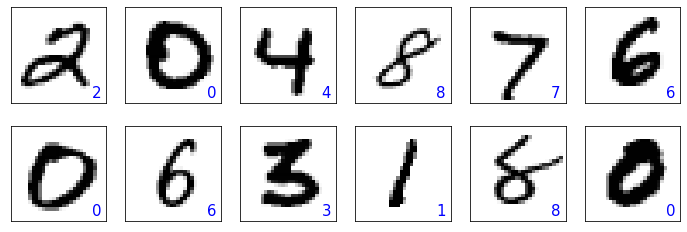

In [50]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('figures/15_13.png', dpi=300)
plt.show()

In questo esempio le previsioni sono tutte corrette. Sull'intero dataset di test ci sono comunque delle mis-classificazioni, perchè l'accuratezza ottenuta è stata molto alta ma non 100%, ovviamente.

In [86]:
# il save dei risultati su file:
import os

if not os.path.exists('models'):
    os.mkdir('models')


model.save('models/mnist-cnn.h5')

## Allenare *convnet* con piccoli dataset (*Chollet*)
Tipicamente, nei problemi reali, il dataset è piccolo, cioè **10^2 - 10^4 immagini**.<br><br>
Le *convnet* possono fornire buone prestazioni anche con questi dataset ("piccoli") se si adotta la giusta strategia:
* si costruisce una CNN *baseline*, senza regolarizzazione (operando sul numero di filtri per regolare l'ampiezza del livello convolutivo);
* poi si fa *data augmentation* per ridurre il rischio di overfitting (oppure con un'altra tecnica di regolarizzazione come ad esempio il dropout visto prima); consiste in un ampliamento del training dataset tramite piccole modifiche casuali alle immagini del training set;
* oppure si utilizza un classificatore pre-allenato (come ad esempio [*ImageNet*](https://it.wikipedia.org/wiki/ImageNet), un dataset di 14 milioni di immagini etichettate su 22000 classi differenti, per lo più oggetti ed animali). 

<u>Bottom-line</u>: non è possibile allenare CNN complesse con piccoli dataset (10^2 immagini); ma **10^3+ immagini possono essere sufficienti se il modello è semplice e ben regolarizzato tramite la *data augmentation* (od altra tecnica)**. 

# Segmentazione di immagini con CNN (esempio di *Chollet*)
La segmentazione delle immagini nel *Deep Learning* utilizza un modello di rete neurale per <u>assegnare una classe ad ogni pixel dell'immagine</u> e quindi segmentare l'immagine in **zone differenti**, come ad esempio: *background* e *foreground*, oppure *strada*, *macchina* e *bordo strada*.<br><br>
Questa tecnica generale può essere utilizzata in molteplici applicazioni; ad esempio:
* editing di immagini e video
* guida autonoma
* robotica
* imaging medicale
* ecc

Ci sono due tipi di segmentazione:

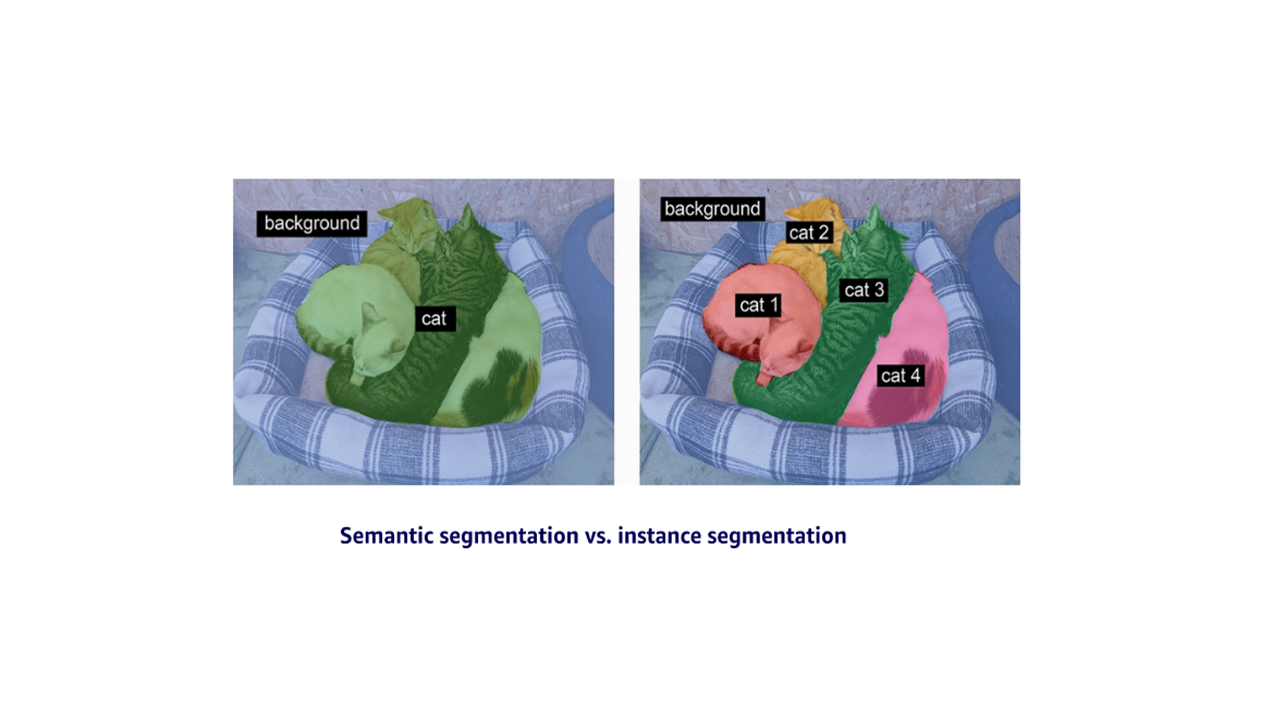

In [6]:
Image(filename='images/semantic_vs_instance_segmentation.png', width=800)

In questo esempio ci concentriamo sulla segmentazione **semantica**.<br><br>
Vediamo come separare l'immagine di un animale domestico dallo sfondo.<br><br>
Dati scaricabili [da qui](https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz) come immagini e da [qui](https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz) come *segmentation mask*.<br>
**NB. Clickando i due link si attiva immediatamente** il download dei due file *tar*, rispettivamente di circa 755 MB e 16 MB.<br><br>
Al termine del download <u>de-comprimere</u> i due file e salvarli in una directory <u>di cui prendere nota</u>.

Il dataset *Oxford-IIIT Pets* contiene **7.390** immagini (in formato *jpeg*) di **cani e gatti** di varie razze insieme alle loro ***segmentation mask*** (aka, *target mask*), che sono l'equivalente di una etichetta (*label*) nei problemi di classificazione, cioè un'immagine della stessa dimensione dell'immagine di input, ma con **un singolo canale colore che rappresenta il valore di classe del pixel**, ad esempio (nel nostro caso): 
* 1 *foreground*
* 2 *background*
* 3 *contorno*

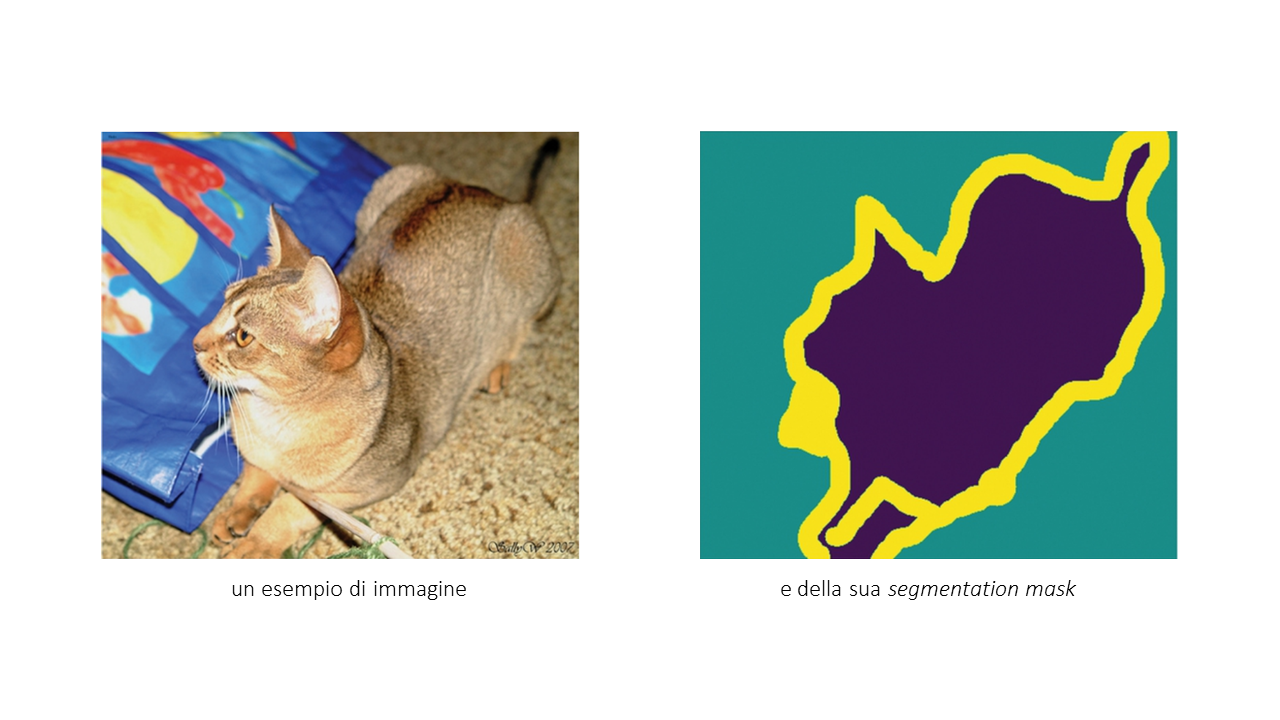

In [151]:
Image(filename='images/image_mask_example.png', width=800)

In [51]:
# la preparazione delle due liste dei cammini (delle immagini e delle corrispondenti segmentation mask):
import os

input_dir = "images/Oxford-IIIT Pets/images"                   # la sotto-directory delle immagini (scelta dell'utente)
target_dir = "images/Oxford-IIIT Pets/annotations/trimaps"     # la sotto-directory delle maschere (scelta dell'utente)

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

In [52]:
print(input_img_paths) # l'elenco delle immagini di input con il loro path

['images/Oxford-IIIT Pets/images\\Abyssinian_1.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_10.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_100.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_101.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_102.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_103.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_104.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_105.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_106.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_107.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_108.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_109.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_11.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_110.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_111.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_112.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_113.jpg', 'images/Oxford-IIIT Pets/images\\Abyssinian_114.jpg', 'images/Oxford-IIIT Pets/images

In [53]:
print(target_paths) # l'elenco delle segmentation mask (delle immagini), dette qui "annotation", con il loro path

['images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_1.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_10.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_100.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_101.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_102.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_103.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_104.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_105.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_106.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_107.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_108.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_109.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_11.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_110.png', 'images/Oxford-IIIT Pets/annotations/trimaps\\Abyssinian_111.png'

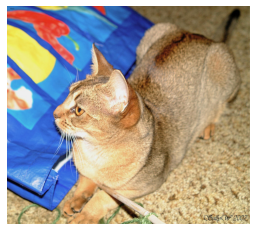

In [56]:
# vediamo ora una di queste immagini (la numero 9):
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

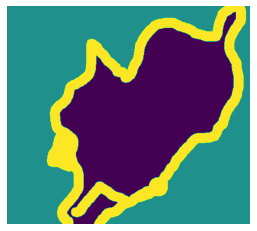

In [57]:
# e la sua maschera corrispondente:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127  # le etichette originarie sono, come detto prima: 1,2 e 3.
                                                                 # sottraiamo 1 per farle diventare: 0,1 e 2.
                                                                 # quindi le moltiplichiamo per 127: così diventano:
                                                                 # 0 (nero), 127 (grigio), 254 (quasi bianco)
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))  # 'color_mode = "grayscale" rende l'immagine caricata
                                                                       # mono-canale (cioè, con un singolo canale colore).
display_target(img)

In [59]:
# ora carichiamo le immagini e le maschere in due array numpy, e poi dividiamo le array in training e test set:
# tempo di esecuzione sul mio PC: circa 10 secondi
import numpy as np
import random

img_size = (200, 200)                                                   # reshape dell'immagine (per renderle tutte 
                                                                        # consistenti come 'aspect_ratio')
    
num_imgs = len(input_img_paths)                                         # il numero totale di immagini

# rimescolamento dei cammini (che erano ordinati per razza); si utilizza lo stesso seme (1337), senza significato in sè,
# per assicurarsi che i cammini di immagini e maschere siano nello stesso ordine.
random.Random(1337).shuffle(input_img_paths)                           
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1                                       # la solita sottrazione --> etichette 0,1,2
    return img

# caricamento di tutte le immagini in un'array float32 e di tutte le maschere (nello stesso ordine) in un'array 'uint8'.
# Le immagini hanno tre canali colore (i valori RGB), le maschere hanno un singolo canale (le etichette 0,1,2).
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

# la suddivisione in training e test set
num_val_samples = 1000                             # il numero di immagini del test set (1000/7390, circa il 13%)
train_input_imgs = input_imgs[:-num_val_samples]   # il training set (immagini)
train_targets = targets[:-num_val_samples]         # il training set (maschere)
val_input_imgs = input_imgs[-num_val_samples:]     # il test set (immagini)
val_targets = targets[-num_val_samples:]           # il test set (maschere)

In [80]:
# possiamo ora definire il modello:

from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)                # il rescale delle immagini nel range 0-1

    # la PRIMA PARTE del modello assomiglia molto alle convnet (le CNN) che abbiamo già visto per la classificazione di immagini:
    # c'è una pila (stack) di livelli Conv2D, le cui dimensioni del canale di filtro (la prima coordinata) aumentano 
    # gradualmente (da 64 a 256). 
    # ad ogni aumento di filtro, inoltre, sotto-campioniamo le immagini tramite le stride (di size 2), cioè di un fattore 2.
    # il size delle immagini, inizialmente 200x200, si riduce quindi alla fine a 25x25
    # (infatti: 200x200 (il size originario) --> 100x100 --> 50x50 --> 25x25).
    # la feature map di output di questa prima parte del modello è di dimensione [25,25,256].

    # nb. l'operazione di sotto-campionamento nelle reti CNN di classificazione NON è fatta con le stride ma con il pooling,
    # come già visto. Per i problemi di segmentazione, invece, per ragioni tecniche è meglio sotto-campionare con il
    # max pooling (Chollet)
    
    # lo scopo di questa prima parte del modello è dunque di comprimere le immagini in feature map più piccole, dove
    # ogni pixel contiene in realtà informazioni su un gruppo di pixel originari più ampio.

    # usiamo, per tutti i livelli, il padding 'same' per evitare che il padding dei bordi delle immagini influenzi le
    # dimensioni delle feature map.
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x) 
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # la SECONDA PARTE del modello, ora.
    # la feature map di output della prima parte del modello era, come detto, di dimensione [25,25,256].
    # ma l'output finale deve avere le stesse dimensioni delle maschere, cioè [200,200,3].
    # dobbiamo quindi realizzare una specie di trasformazione inversa, cioè di SOVRA-campionamento.
    # questo è proprio lo scopo dei livelli 'Conv2DTranspose': è una sorta di livello di convoluzione che impara
    # sovra-campionando.
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    # a fine modello aggiungiamo un livello softmax a tre uscite per assegnare le probabilità di classe (1,2,3) ad ogni pixel.
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 100, 100, 64)      1792      
                                                                 
 conv2d_18 (Conv2D)          (None, 100, 100, 64)      36928     
                                                                 
 conv2d_19 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 conv2d_20 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_21 (Conv2D)          (None, 25, 25, 256)       2951

In [81]:
# ora la compilazione ed il fit.
# il fit richiede circa 10-12 minuti (sul mio PC) per ogni epoca. dunque il fit richiesto su 50 epoche richiede circa 10 ore.
import time
start_time = time.time()

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50, # in questa prova ho usato 5
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))

print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/50
  9/100 [=>............................] - ETA: 10:05 - loss: 1.1305

KeyboardInterrupt: 

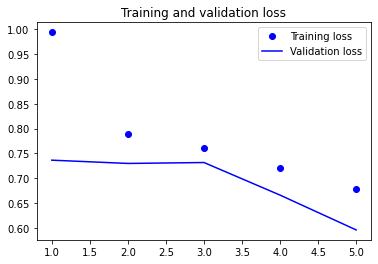

In [125]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
                      # con 5 epoche

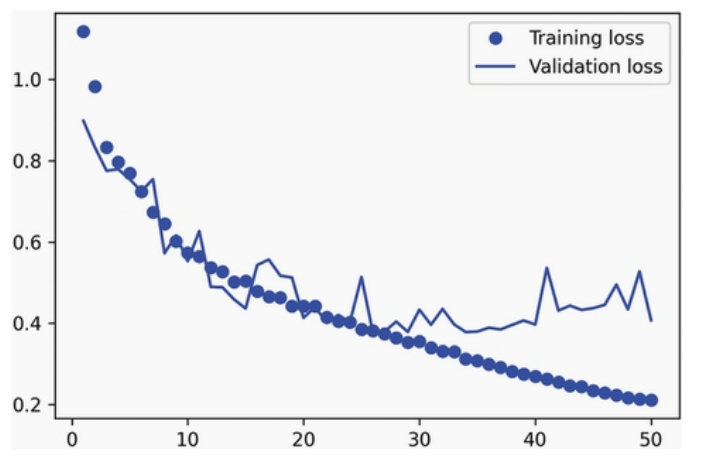

In [133]:
Image(filename='images/loss_curves.png', width=380)  # le stesse curve con 50 epoche.
                                                     # intorno a 20-25 epoche il modello inizia ad andare in overfitting,
                                                     # perchè la loss di training continua a diminuire e la loss di test
                                                     # rimane invece circa stabile e poi aumenta.

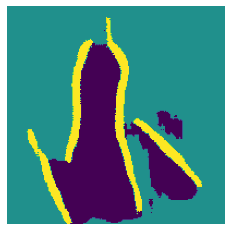

In [206]:
# Infine, carichiamo il miglior modello (in base agli score del test set) e vediamo come usarlo per prevedere una maschera
# di segmentazione:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras") # il modello migliore.
                                                             # la procedura normale è prendere il modello della epoca
                                                             # ottimale (25?)

i = 4 # l'immagine da prevedere
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

# definiamo una utility per visualizzare la previsione del modello:
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

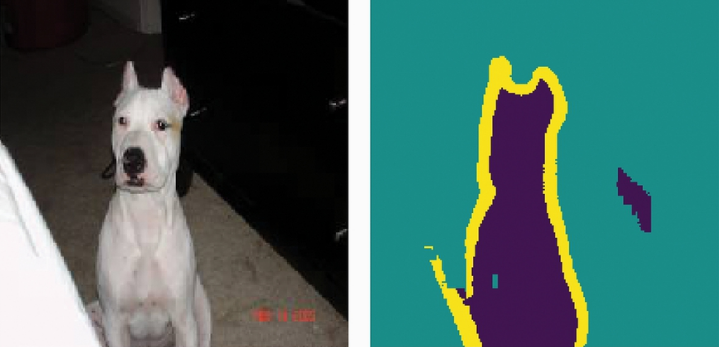

In [136]:
Image(filename='images/test_mask_prediction.png', width=800) # un'immagine effettiva di test e la sua maschera prevista
                                                             # con il miglior modello fittato con 50 epoche